In [1]:
# Numpy
import numpy as np
import pandas as pd
%matplotlib nbagg
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy.stats
import scipy.interpolate

# Machine learning
import tensorflow as tf
import keras
import sklearn
import sklearn.preprocessing, sklearn.base, sklearn.utils, sklearn.model_selection, sklearn.gaussian_process, sklearn.linear_model
import optunity
import statsmodels.nonparametric.smoothers_lowess

# Various Python tricks and libraries
import requests
import time
import functools
import operator
import collections
from tqdm import tqdm, tqdm_notebook, tnrange
import dill as pickle
import IPython
import gc

# Parallel
import joblib
import multiprocessing

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def read_log():
    jobs = pd.read_csv(filepath_or_buffer='ml_queue.log', sep='\s+', header='infer', skiprows=[1], na_values=['UNLIMITED','Unknown','kijana','root']).dropna()

    jobs.loc[:, 'Submit'] = pd.to_datetime(jobs.loc[:, 'Submit'].copy(), errors='coerce')
    jobs.loc[:, 'Start'] = pd.to_datetime(jobs.loc[:, 'Start'].copy(), errors='coerce')
    jobs.loc[:, 'End'] = pd.to_datetime(jobs.loc[:, 'End'].copy(), errors='coerce')

    jobs.loc[:, 'NNodes'] = pd.to_numeric(jobs.loc[:, 'NNodes'].copy(), errors='coerce', downcast='integer')

    jobs.loc[:, 'Timelimit'] = jobs.loc[:, 'Timelimit'].copy().str.replace('-','day ')
    jobs.loc[:, 'Timelimit'] = pd.to_timedelta(jobs.loc[:, 'Timelimit'].copy(), errors='coerce')
    
    jobs.loc[:, 'Waited'] = (jobs.Start - jobs.Submit).values / pd.Timedelta('1h')

#     jobs = jobs[(np.abs(scipy.stats.zscore(jobs.loc[:,'Wait'].values / pd.Timedelta('1h'))) <3)]
    jobs = jobs.dropna()
    
    jobs = jobs.sort_values(by = 'Submit')
    
    return jobs

In [3]:
jobs = read_log()

In [ ]:
def sample(tuple_):
    
    jobs, index, row = tuple_
    
    tj = thisjob = row
    now = tj.Submit
    
    rj = relatedjobs = jobs.loc[np.logical_and.reduce([jobs.index != index, jobs.Submit <= now, jobs.End > now])] # excludes thisjob, includes jobs submitted simultaneously but ranked earlier
    
    # 无关人等滚开
    if now < jobs.End.min() or index < 100 or index == 10826:
        return None
        
    # 零、有空位，就不用等。
    if rj.NNodes.sum() + tj.NNodes <= 29 and np.sum(rj.User == tj.User)<10 and rj.loc[rj.User == tj.User].NNodes.sum() + tj.NNodes<16:
        assert tj.Waited <= 0.3
        
    # 一、各种descriptor
    analysis = pd.DataFrame([], index=[index])
    
    analysis.loc[:, 'NNodes'] = tj.NNodes
    analysis.loc[:, 'ETA']    = tj.Timelimit
    
    analysis.loc[:, 'Total_squeue_nnodes'] = rj.NNodes.sum()
    
    analysis.loc[:, 'Total_squeue_eta']    = rj.Timelimit.sum()
    
    analysis.loc[:, 'Self_job_in_squeue_percentage'] = 0 if len(rj)==0 else float(np.sum(rj.User == tj.User)) / len(rj)
    
    analysis.loc[:, 'Waited'] = tj.Waited
    
    return analysis
    
    
L = multiprocessing.Pool(processes=20).map(sample, [(jobs, index, row.copy()) for index, row in tqdm(jobs.iterrows(), total=len(jobs))])
analyses = pd.concat(L) # None is automatically ignored

In [5]:
normalize_analyses =   pd.DataFrame(sklearn.preprocessing.scale(analyses.apply(pd.to_numeric).values), index=analyses.index, columns=analyses.columns)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(normalize_analyses.drop('Waited', axis=1), normalize_analyses.Waited, test_size=0.3)


/home/xzhang1/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [6]:
normalize_analyses.corr()

,NNodes,ETA,Total_squeue_nnodes,Total_squeue_eta,Self_job_in_squeue_percentage,Waited
NNodes,1.000000,0.190355,0.080088,-0.050471,-0.028755,0.099774
ETA,0.190355,1.000000,-0.103747,0.061354,-0.015285,0.035756
Total_squeue_nnodes,0.080088,-0.103747,1.000000,0.796837,0.281878,0.268566
Total_squeue_eta,-0.050471,0.061354,0.796837,1.000000,0.314577,0.208456
Self_job_in_squeue_percentage,-0.028755,-0.015285,0.281878,0.314577,1.000000,0.069396
Waited,0.099774,0.035756,0.268566,0.208456,0.069396,1.000000


# 求$\hat{W}(t, J, E, \cdots)$

## GPR

In [ ]:
gpr = sklearn.gaussian_process.GaussianProcessRegressor(alpha=1e-3).fit(X_train, y_train)
yhat_train = gpr.predict(X_train)
yhat_test = gpr.predict(X_test)

<IPython.core.display.Javascript object>


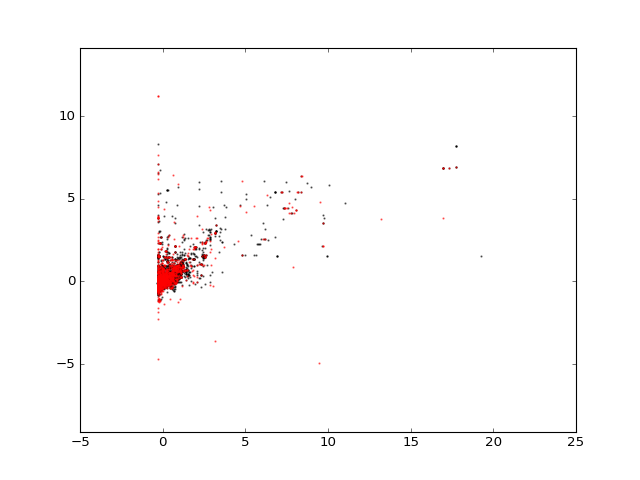

In [37]:
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='datalim')
ax.scatter(y_train, yhat_train, s=1, color='black', alpha=0.5, label='train') # R2=0.40
ax.scatter(y_test, yhat_test, s=1, color='red', alpha=0.5, label='test') # R2=0.33

## 找一个收敛的神经网络

In [19]:
class Minibatch(object):
    '''
    Makes batches from dataframes.
    Executes n_epochs before raising StopIteration and dying.
    Allows setting aside a test set.
    Progress bar.
    '''
    
    def __init__(self, df, minibatch_size, n_epochs, test_split, tqdm=None):
        self.minibatch_size = minibatch_size
        
        N = len(df)
        test_size = int(N * test_split)
        test_index = np.random.choice(N, test_size, replace=False)
        training_index = list(set(range(N)) - set(test_index))
        self.test_df = df.iloc[test_index]
        self.training_df = df.iloc[training_index]
        self.df = df

        self.i = 0
        self.iMAX = n_epochs * len(self.training_df) / minibatch_size
        
        if tqdm:
            self.tqdm = tqdm_notebook(total=self.iMAX, leave=False)
        
    def minibatch(self):
        if self.i > self.iMAX:
            self.i = 0
            raise StopIteration
        else:
            self.i += 1
            
        if getattr(self, 'tqdm', None):
            self.tqdm.update(1)
        
        index = np.random.choice(range(len(self.training_df)), self.minibatch_size, replace=False)
        return self.training_df.iloc[index, :-1].values, self.training_df.iloc[index, -1].values.reshape(-1, 1)
    
    def training_set(self):
        return self.training_df.iloc[:, :-1].values, self.training_df.iloc[:, -1].values.reshape(-1, 1)
    
    def test_set(self):
        return self.test_df.iloc[:, :-1].values, self.test_df.iloc[:, -1].values.reshape(-1, 1)

In [28]:
minibatch_size = 32
n_epochs = 100
ns_units = [10, 6, 3, 1]
lr = 1E-2

# Graph
tf.reset_default_graph()

X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 5])

h = X
for n_units in ns_units:
    h = tf.layers.dense(h, units=n_units, activation=tf.nn.elu)
yhat = h

y = tf.placeholder(name="y", dtype=tf.float32, shape=[None, 1])

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(loss)

# Session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

m = Minibatch(normalize_analyses, minibatch_size, n_epochs, test_split=0.2, tqdm=True)
while True:
    try:
        _X, _y = m.minibatch()
        sess.run(training_op, feed_dict = {X: _X, y: _y})
    except StopIteration:
        break
    
_X_train, _y_train = m.training_set()
_yhat_train = sess.run(yhat, feed_dict = {X: _X_train})

_X_test, _y_test = m.test_set()
_yhat_test = sess.run(yhat, feed_dict = {X: _X_test})

sess.close()

HBox(children=(IntProgress(value=0, max=32962), HTML(value=u'')))

<IPython.core.display.Javascript object>


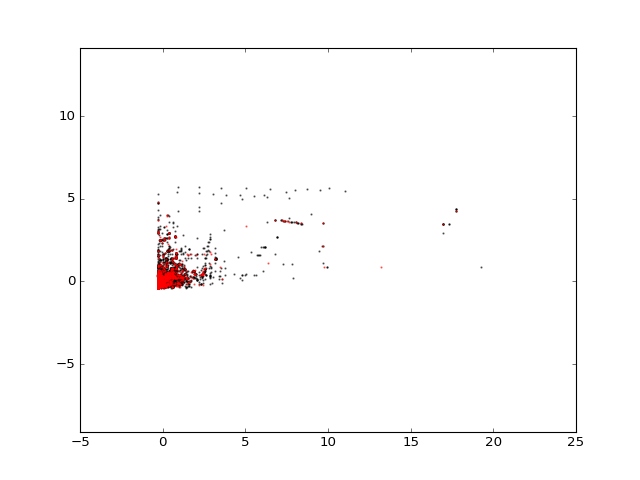

In [38]:
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='datalim')
ax.scatter(_y_train, _yhat_train, s=1, color='black', alpha=0.5, label='train') # R2=0.34
ax.scatter(_y_test, _yhat_test, s=1, color='red', alpha=0.5, label='test') # R2=0.32

## 四处看看有没有更好的

In [42]:
class BetterYhatLive(object):
    
    def __init__(self):
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(14, 4.2))
        self.ax2.set_aspect('equal', adjustable='datalim')
        self.line11, self.line12 = [], []
        
    def update(self, y_train, yhat_train, y_test, yhat_test):
        self.line11.append(sklearn.metrics.r2_score(y_train, yhat_train))
        self.line12.append(sklearn.metrics.r2_score(y_test, yhat_test))
        self.ax1.clear()
        self.ax1.plot(self.line11, label='R2(train)=%.2f'%self.line11[-1])
        self.ax1.plot(self.line12, label='R2(test)=%.2f'%self.line12[-1])
        self.ax1.legend(loc='best')
        self.ax2.clear()
        self.ax2.scatter(y_train, yhat_train, color='green', s=1, alpha=0.5, label='train')
        self.ax2.scatter(y_test, yhat_test, color='red', s=1, alpha=0.5, label='test')
        self.ax2.legend(loc='best')
        self.fig.canvas.draw()

HBox(children=(IntProgress(value=0, max=32962), HTML(value=u'')))

<IPython.core.display.Javascript object>


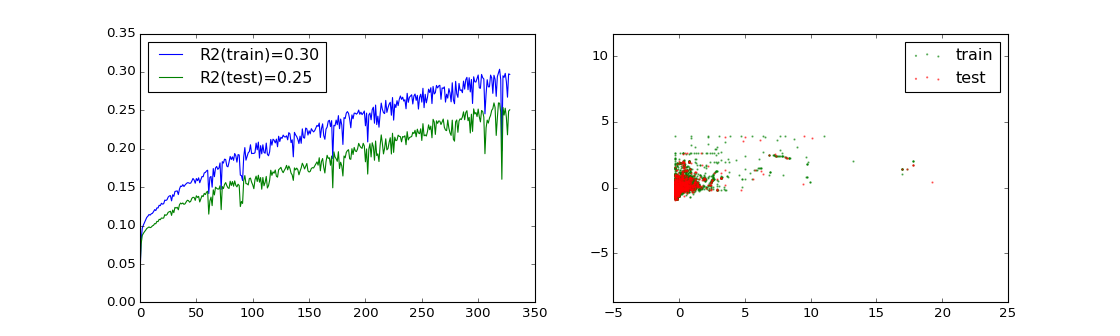

In [43]:
minibatch_size = 32
n_epochs = 100
ns_units = [10, 6, 3, 1]
lr = 1E-2

# Graph
tf.reset_default_graph()

X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 5])

h = X
for n_units in ns_units:
    h = tf.layers.dense(h, units=n_units, activation=tf.nn.elu)
yhat = h

y = tf.placeholder(name="y", dtype=tf.float32, shape=[None, 1])

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(loss)

# Session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

m = Minibatch(normalize_analyses, minibatch_size, n_epochs, test_split=0.2, tqdm=True)
b = BetterYhatLive()
while True:
    try:
        _X, _y = m.minibatch()
        sess.run(training_op, feed_dict = {X: _X, y: _y})
        
        if m.i % 100 == 0:
            X_train, y_train = m.training_set()
            yhat_train = sess.run(yhat, feed_dict = {X: X_train})
            X_test, y_test = m.test_set()
            yhat_test = sess.run(yhat, feed_dict = {X: X_test}) 
            b.update(y_train, yhat_train, y_test, yhat_test)
    except StopIteration:
        break
    


sess.close()

抹除outlier

### 首先抹除0

In [4]:
def read_log():
    jobs = pd.read_csv(filepath_or_buffer='ml_queue.log', sep='\s+', header='infer', skiprows=[1], na_values=['UNLIMITED','Unknown','kijana','root']).dropna()

    jobs.loc[:, 'Submit'] = pd.to_datetime(jobs.loc[:, 'Submit'].copy(), errors='coerce')
    jobs.loc[:, 'Start'] = pd.to_datetime(jobs.loc[:, 'Start'].copy(), errors='coerce')
    jobs.loc[:, 'End'] = pd.to_datetime(jobs.loc[:, 'End'].copy(), errors='coerce')

    jobs.loc[:, 'NNodes'] = pd.to_numeric(jobs.loc[:, 'NNodes'].copy(), errors='coerce', downcast='integer')

    jobs.loc[:, 'Timelimit'] = jobs.loc[:, 'Timelimit'].copy().str.replace('-','day ')
    jobs.loc[:, 'Timelimit'] = pd.to_timedelta(jobs.loc[:, 'Timelimit'].copy(), errors='coerce')
    
    jobs.loc[:, 'Waited'] = (jobs.Start - jobs.Submit).values / pd.Timedelta('1h')

    # jobs = jobs[(np.abs(scipy.stats.zscore(jobs.loc[:,'Wait'].values / pd.Timedelta('1h'))) <3)]
    jobs = jobs.dropna()
    
    # jobs = jobs.sort_values(by = 'Submit')
    # 几乎总是sorted
    
    return jobs

In [5]:
jobs = read_log()

In [46]:
def count_violation_on_one(tuple_):
    jobs, nnodes, nselfjobs, nselfnodes, index, tj = tuple_
    
    now = tj.Submit
    
    rj = jobs.loc[np.logical_and.reduce([jobs.index != index, jobs.Submit <= now, jobs.End > now])] # excludes thisjob, includes jobs submitted simultaneously but ranked earlier
    
    # 无关人等滚开
    if now < jobs.End.min() or index < 100:
        return 0
        
    # 零、有空位，就不用等。
    nowait_criterion = rj.NNodes.sum() + tj.NNodes <= nnodes and np.sum(rj.User == tj.User)<=nselfjobs and rj.loc[rj.User == tj.User].NNodes.sum() + tj.NNodes<=nselfnodes 
    nowait = tj.Waited <= 0.05

    return int(nowait != nowait_criterion)

def count_violations_int(nnodes, nselfjobs, nselfnodes):
    L = multiprocessing.Pool(processes=20).map(count_violation_on_one, [(jobs, nnodes, nselfjobs, nselfnodes, index, row.copy()) for index, row in jobs.iterrows()])
    return np.sum(L)

def count_violations(nnodes, nselfjobs, nselfnodes):
    nnodes, nselfjobs, nselfnodes = map(int, [nnodes, nselfjobs, nselfnodes])
    if (nnodes, nselfjobs, nselfnodes) in count_violations.d:
        result = count_violations.d[(nnodes, nselfjobs, nselfnodes)]
    else:
        result = count_violations_int(nnodes, nselfjobs, nselfnodes)
        count_violations.d[(nnodes, nselfjobs, nselfnodes)] = result
    print "%8s, %8s, %8s, %8s" % (nnodes, nselfjobs, nselfnodes, result)
    return result
    
count_violations.d = {}


In [50]:
search_space = {
    'nnodes': [28, 40],
    'nselfjobs': [10, 30],
    'nselfnodes': [10, 36]
}
optunity.minimize_structured(count_violations, search_space=search_space, num_evals=100) #[35, 14, something]

      31,       14,       27,     3155
      37,       24,       14,     3621
      29,       10,       13,     4130
      35,       20,       26,     2767
      32,       25,       32,     2471
      38,       15,       19,     3256
      31,       23,       16,     3559
      37,       13,       29,     3011
      28,       18,       23,     3476
      34,       28,       10,     4136
      31,       15,       29,     3104
      36,       25,       16,     3417
      30,       12,       15,     3864
      34,       22,       28,     2616
      32,       26,       31,     2546
      37,       17,       21,     3120
      31,       24,       18,     3396
      36,       14,       31,     2928
      28,       19,       24,     3408
      33,       26,       11,     4051
      32,       17,       31,     2891
      36,       27,       18,     3247
      31,       13,       16,     3595
      33,       23,       29,     2604
      32,       25,       31,     2552
      36,       18,      

({'nnodes': 33.165843201382685,
  'nselfjobs': 28.33516990547566,
  'nselfnodes': 32.93078125},
 optimize_results(optimum=2383, stats=OrderedDict([('num_evals', 97), ('time', 2082.616770029068)]), call_log={'args': {'nselfnodes': [27.92578125, 14.92578125, 13.30078125, 26.30078125, 32.80078125, 19.80078125, 16.55078125, 29.55078125, 23.05078125, 10.05078125, 29.74578125, 16.74578125, 15.12078125, 28.12078125, 31.053794387106546, 21.62078125, 18.37078125, 31.37078125, 24.717506718941962, 11.87078125, 31.56578125, 18.56578125, 16.94078125, 29.94078125, 31.54396951192955, 23.44078125, 20.19078125, 33.19078125, 26.537506718941962, 13.69078125, 33.38578125, 20.38578125, 18.76078125, 31.76078125, 32.57881426002138, 25.26078125, 22.01078125, 34.420709221323506, 28.357506718941963, 15.51078125, 34.818692036927125, 22.20578125, 20.58078125, 33.58078125, 33.72130984610183, 27.08078125, 23.83078125, 34.28096192118915, 30.177506718941963, 17.33078125, 35.99053513357579, 24.02578125, 22.40078125, 3

### 只考虑总Node数

In [4]:
def count_violation_on_one(tuple_):
    jobs, nnodes, index, tj = tuple_
    
    now = tj.Submit
    
    rj = jobs.loc[np.logical_and.reduce([jobs.index != index, jobs.Submit <= now, jobs.End > now])] # excludes thisjob, includes jobs submitted simultaneously but ranked earlier
    
    # 无关人等滚开
    if now < jobs.End.min() or index < 100:
        return 0
        
    # 零、有空位，就不用等。
    nowait_criterion = rj.NNodes.sum() + tj.NNodes <= nnodes
    nowait = tj.Waited <= 0.05

    return int(nowait != nowait_criterion)

def count_violations_int(nnodes):
    L = multiprocessing.Pool(processes=20).map(count_violation_on_one, [(jobs, nnodes, index, row.copy()) for index, row in jobs.iterrows()])
    return np.sum(L)

def count_violations(nnodes):
    nnodes = int(nnodes)
    if nnodes in count_violations.d:
        result = count_violations.d[nnodes]
    else:
        result = count_violations_int(nnodes)
        count_violations.d[nnodes] = result
    print "%8s, %8s" % (nnodes, result)
    return result
    
count_violations.d = {}


In [ ]:
search_space2 = {
    'nnodes': [30, 50]
}
optunity.minimize_structured(count_violations, search_space=search_space2, num_evals=10)

### 阈值？

In [12]:
def count_violation_on_one(tuple_):
    jobs, nnodes, nselfjobs, nselfnodes, index, tj = tuple_
    
    now = tj.Submit
    
    rj = jobs.loc[np.logical_and.reduce([jobs.index != index, jobs.Submit <= now, jobs.End > now])] # excludes thisjob, includes jobs submitted simultaneously but ranked earlier
    
    # 无关人等滚开
    if now < jobs.End.min() or index < 100:
        return 0
        
    # 零、有空位，就不用等。
    nowait_criterion = rj.NNodes.sum() + tj.NNodes <= nnodes and np.sum(rj.User == tj.User)<=nselfjobs and rj.loc[rj.User == tj.User].NNodes.sum() + tj.NNodes<=nselfnodes 
    nowait = tj.Waited <= 0.005

    return int(nowait != nowait_criterion)

def count_violations_int(nnodes, nselfjobs, nselfnodes):
    L = multiprocessing.Pool(processes=20).map(count_violation_on_one, [(jobs, nnodes, nselfjobs, nselfnodes, index, row.copy()) for index, row in jobs.iterrows()])
    return np.sum(L)

def count_violations(nnodes, nselfjobs, nselfnodes):
    nnodes, nselfjobs, nselfnodes = map(int, [nnodes, nselfjobs, nselfnodes])
    if (nnodes, nselfjobs, nselfnodes) in count_violations.d:
        result = count_violations.d[(nnodes, nselfjobs, nselfnodes)]
    else:
        result = count_violations_int(nnodes, nselfjobs, nselfnodes)
        count_violations.d[(nnodes, nselfjobs, nselfnodes)] = result
    print "%8s, %8s, %8s, %8s" % (nnodes, nselfjobs, nselfnodes, result)
    return result
    
count_violations.d = {}


In [ ]:
search_space = {
    'nnodes': [28, 40],
    'nselfjobs': [10, 30],
    'nselfnodes': [10, 36]
}
optunity.minimize_structured(count_violations, search_space=search_space, num_evals=100) #[35, 14, something]

In [13]:
count_violations(33, 28, 32)

      33,       28,       32,     1840


1840

In [14]:
def count_violation_on_one(tuple_):
    jobs, nnodes, index, tj = tuple_
    
    now = tj.Submit
    
    rj = jobs.loc[np.logical_and.reduce([jobs.index != index, jobs.Submit <= now, jobs.End > now])] # excludes thisjob, includes jobs submitted simultaneously but ranked earlier
    
    # 无关人等滚开
    if now < jobs.End.min() or index < 100:
        return 0
        
    # 零、有空位，就不用等。
    nowait_criterion = rj.NNodes.sum() + tj.NNodes <= nnodes
    nowait = tj.Waited <= 0.005

    return int(nowait != nowait_criterion)

def count_violations_int(nnodes):
    L = multiprocessing.Pool(processes=20).map(count_violation_on_one, [(jobs, nnodes, index, row.copy()) for index, row in jobs.iterrows()])
    return np.sum(L)

def count_violations(nnodes):
    nnodes = int(nnodes)
    if nnodes in count_violations.d:
        result = count_violations.d[nnodes]
    else:
        result = count_violations_int(nnodes)
        count_violations.d[nnodes] = result
    print "%8s, %8s" % (nnodes, result)
    return result
    
count_violations.d = {}


In [15]:
search_space2 = {
    'nnodes': [30, 50]
}
optunity.minimize_structured(count_violations, search_space=search_space2, num_evals=10)

      35,     1778
      45,     1672
      40,     1627
      30,     2134
      31,     2022
      41,     1624
      46,     1684
      36,     1607
      38,     1575
      48,     1750


({'nnodes': 38.720703125},
 optimize_results(optimum=1575, stats=OrderedDict([('num_evals', 10), ('time', 87.76712393760681)]), call_log={'args': {'nnodes': [35.908203125, 45.908203125, 40.908203125, 30.908203125, 31.220703125, 41.220703125, 46.220703125, 36.220703125, 38.720703125, 48.720703125]}, 'values': [1778, 1672, 1627, 2134, 2022, 1624, 1684, 1607, 1575, 1750]}, report=None),
 {'nnodes': [30, 50],
  'num_generations': 1,
  'num_particles': 10,
  'solver_name': 'particle swarm'})

### I类与II类错

In [20]:
def count_violation_on_one(tuple_):
    jobs, nnodes, nselfjobs, nselfnodes, index, tj = tuple_
    
    now = tj.Submit
    
    rj = jobs.loc[np.logical_and.reduce([jobs.index != index, jobs.Submit <= now, jobs.End > now])] # excludes thisjob, includes jobs submitted simultaneously but ranked earlier
    
    # 无关人等滚开
    if now < jobs.End.min() or index < 100:
        return [False, False]
        
    # 零、有空位，就不用等。
    nowait_criterion = rj.NNodes.sum() + tj.NNodes <= nnodes and np.sum(rj.User == tj.User)<=nselfjobs and rj.loc[rj.User == tj.User].NNodes.sum() + tj.NNodes<=nselfnodes 
    nowait = tj.Waited <= 0.005

    return (nowait and not nowait_criterion, nowait_criterion and not nowait)

def count_violations_int(nnodes, nselfjobs, nselfnodes):
    L = multiprocessing.Pool(processes=20).map(count_violation_on_one, [(jobs, nnodes, nselfjobs, nselfnodes, index, row.copy()) for index, row in jobs.iterrows()])
    return np.sum(np.array(L), axis=0)

def count_violations(nnodes, nselfjobs, nselfnodes):
    nnodes, nselfjobs, nselfnodes = map(int, [nnodes, nselfjobs, nselfnodes])
    if (nnodes, nselfjobs, nselfnodes) in count_violations.d:
        result = count_violations.d[(nnodes, nselfjobs, nselfnodes)]
    else:
        result = count_violations_int(nnodes, nselfjobs, nselfnodes)
        count_violations.d[(nnodes, nselfjobs, nselfnodes)] = result
    print "%8s, %8s, %8s, %8s" % (nnodes, nselfjobs, nselfnodes, result)
    return result
    
count_violations.d = {}


In [21]:
count_violations(33, 28, 32)

      33,       28,       32, [1749   91]


array([1749,   91])

Process PoolWorker-141:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
Process PoolWorker-154:
Process PoolWorker-144:
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
Process PoolWorker-143:
    task = get()
Process PoolWorker-149:
Process PoolWorker-157:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process PoolWorker-159:
Process PoolWorker-142:
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process PoolWorker-146:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/pyt

    task = get()
    task = get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
KeyboardInterrupt
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
    task = get()
    racquire()
    racquire()
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
KeyboardInterrupt
    racquire()
KeyboardInterrupt
Process PoolWorker-158:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


In [22]:
count_violations(32, 16, 24)

      32,       16,       24, [2459   44]


array([2459,   44])

Process PoolWorker-176:
Process PoolWorker-170:
Process PoolWorker-172:
Process PoolWorker-177:
Process PoolWorker-168:
Process PoolWorker-173:
Process PoolWorker-171:
Process PoolWorker-165:
Process PoolWorker-166:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process PoolWorker-174:
Process PoolWorker-164:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process PoolWorker-178:
Traceback (most recent call last):
Process PoolWorker-179:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process PoolWorker-175:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/py

  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
KeyboardInterrupt
KeyboardInterrupt
    racquire()
    racquire()
    racquire()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
    self.run()
Process PoolWorker-161:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
Traceback (most recent call last):
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    self.run()
    task = get()


In [14]:
def count_violation_on_one(tuple_):
    jobs, nnodes, index, tj = tuple_
    
    now = tj.Submit
    
    rj = jobs.loc[np.logical_and.reduce([jobs.index != index, jobs.Submit <= now, jobs.End > now])] # excludes thisjob, includes jobs submitted simultaneously but ranked earlier
    
    # 无关人等滚开
    if now < jobs.End.min() or index < 100:
        return [False, False]
        
    # 零、有空位，就不用等。
    nowait_criterion = rj.NNodes.sum() + tj.NNodes <= nnodes
    nowait = tj.Waited <= 0.005

    return (nowait and not nowait_criterion, nowait_criterion and not nowait)

def count_violations_int(nnodes):
    L = multiprocessing.Pool(processes=20).map(count_violation_on_one, [(jobs, nnodes, index, row.copy()) for index, row in jobs.iterrows()])
    return np.sum(np.array(L), axis=0)

def count_violations(nnodes):
    nnodes = int(nnodes)
    if nnodes in count_violations.d:
        result = count_violations.d[nnodes]
    else:
        result = count_violations_int(nnodes)
        count_violations.d[nnodes] = result
    print "%8s, %8s" % (nnodes, result)
    return result
    
count_violations.d = {}


In [15]:
count_violations_int(38)

array([1143,  432])

Process PoolWorker-64:
Process PoolWorker-77:
Process PoolWorker-75:
Process PoolWorker-80:
Traceback (most recent call last):
Process PoolWorker-62:
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-70:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process PoolWorker-71:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process PoolWorker-76:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
    task = get()
  File "/usr/lib/python

    racquire()
    racquire()
KeyboardInterrupt
    racquire()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    task = get()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    racquire()
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
KeyboardInterrupt


In [16]:
count_violations_int(36)

array([1287,  320])

Process PoolWorker-93:
Process PoolWorker-88:
Process PoolWorker-81:
Process PoolWorker-84:
Process PoolWorker-99:
Process PoolWorker-96:
Process PoolWorker-89:
Process PoolWorker-86:
Process PoolWorker-92:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process PoolWorker-97:
Process PoolWorker-87:
Process PoolWorker-83:
Process PoolWorker-100:
Traceback (most recent call last):
Process PoolWorker-94:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process PoolWorker-91:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process PoolWorker-85:
Process PoolWorker-82:
    self.run()
Process PoolWorker-90:
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line

  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
    return recv()
    racquire()
    racquire()
    racquire()
    racquire()
    racquire()
    racquire()
    racquire()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102,

In [17]:
count_violations_int(32)

array([1791,   52])

## 既然去掉了0, 效果如何？

In [4]:
def read_log():
    jobs = pd.read_csv(filepath_or_buffer='ml_queue.log', sep='\s+', header='infer', skiprows=[1], na_values=['UNLIMITED','Unknown','kijana','root']).dropna()

    jobs.loc[:, 'Submit'] = pd.to_datetime(jobs.loc[:, 'Submit'].copy(), errors='coerce')
    jobs.loc[:, 'Start'] = pd.to_datetime(jobs.loc[:, 'Start'].copy(), errors='coerce')
    jobs.loc[:, 'End'] = pd.to_datetime(jobs.loc[:, 'End'].copy(), errors='coerce')

    jobs.loc[:, 'NNodes'] = pd.to_numeric(jobs.loc[:, 'NNodes'].copy(), errors='coerce', downcast='integer')

    jobs.loc[:, 'Timelimit'] = jobs.loc[:, 'Timelimit'].copy().str.replace('-','day ')
    jobs.loc[:, 'Timelimit'] = pd.to_timedelta(jobs.loc[:, 'Timelimit'].copy(), errors='coerce')
    
    jobs.loc[:, 'Waited'] = (jobs.Start - jobs.Submit).values / pd.Timedelta('1h')

    # jobs = jobs[(np.abs(scipy.stats.zscore(jobs.loc[:,'Wait'].values / pd.Timedelta('1h'))) <3)]
    jobs = jobs.dropna()
    
    # jobs = jobs.sort_values(by = 'Submit')
    # 几乎总是sorted
    
    return jobs

In [5]:
jobs = read_log()

In [ ]:
def sample(tuple_):
    
    jobs, index, row = tuple_
    
    tj = thisjob = row
    now = tj.Submit
    
    rj = relatedjobs = jobs.loc[np.logical_and.reduce([jobs.index != index, jobs.Submit <= now, jobs.End > now])] # excludes thisjob, includes jobs submitted simultaneously but ranked earlier
    
    # 无关人等滚开
    if now < jobs.End.min() or index < 100 or index == 10826:
        return None
        
    # 零、有空位，就不用等。
    if rj.NNodes.sum() + tj.NNodes <= 36:
        # 几乎总是tj.Waited < 0.005
        return None
        
    # 一、各种descriptor
    analysis = pd.DataFrame([], index=[index])
    
    analysis.loc[:, 'NNodes'] = tj.NNodes
    analysis.loc[:, 'ETA']    = tj.Timelimit
    
    analysis.loc[:, 'Total_squeue_nnodes'] = rj.NNodes.sum()
    
    analysis.loc[:, 'Total_squeue_eta']    = rj.Timelimit.sum()
    
    analysis.loc[:, 'Self_job_in_squeue_percentage'] = 0 if len(rj)==0 else float(np.sum(rj.User == tj.User)) / len(rj)
    
    analysis.loc[:, 'Waited'] = tj.Waited
    
    return analysis
    
    
L = multiprocessing.Pool(processes=20).map(sample, [(jobs, index, row.copy()) for index, row in tqdm(jobs.iterrows(), total=len(jobs))])
analyses = pd.concat(L) # None is automatically ignored

In [7]:
normalize_analyses = pd.DataFrame(
    sklearn.preprocessing.scale(
        analyses.apply(pd.to_numeric).values
    ), 
    index=analyses.index, 
    columns=analyses.columns
)

/home/xzhang1/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [8]:
len(jobs)

13281

In [9]:
len(normalize_analyses)

8088

In [10]:
class BetterYhatLive(object):
    
    def __init__(self):
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(14, 4.2))
        self.ax2.set_aspect('equal', adjustable='datalim')
        self.line11, self.line12 = [], []
        
    def update(self, y_train, yhat_train, y_test, yhat_test):
        self.line11.append(sklearn.metrics.r2_score(y_train, yhat_train))
        self.line12.append(sklearn.metrics.r2_score(y_test, yhat_test))
        self.ax1.clear()
        self.ax1.plot(self.line11, label='R2(train)=%.2f'%self.line11[-1])
        self.ax1.plot(self.line12, label='R2(test)=%.2f'%self.line12[-1])
        self.ax1.legend(loc='best')
        self.ax2.clear()
        self.ax2.scatter(y_train, yhat_train, color='green', s=1, alpha=0.5, label='train')
        self.ax2.scatter(y_test, yhat_test, color='red', s=1, alpha=0.5, label='test')
        self.ax2.legend(loc='best')
        self.fig.canvas.draw()

In [13]:
class Minibatch(object):
    '''
    Makes batches from dataframes.
    Executes n_epochs before raising StopIteration and dying.
    Allows setting aside a test set.
    Progress bar.
    '''
    
    def __init__(self, df, minibatch_size, n_epochs, test_split, tqdm=None):
        self.minibatch_size = minibatch_size
        
        N = len(df)
        test_size = int(N * test_split)
        test_index = np.random.choice(N, test_size, replace=False)
        training_index = list(set(range(N)) - set(test_index))
        self.test_df = df.iloc[test_index]
        self.training_df = df.iloc[training_index]
        self.df = df

        self.i = 0
        self.iMAX = n_epochs * len(self.training_df) / minibatch_size
        
        if tqdm:
            self.tqdm = tqdm_notebook(total=self.iMAX, leave=False)
        
    def minibatch(self):
        if self.i > self.iMAX:
            self.i = 0
            raise StopIteration
        else:
            self.i += 1
            
        if getattr(self, 'tqdm', None):
            self.tqdm.update(1)
        
        index = np.random.choice(range(len(self.training_df)), self.minibatch_size, replace=False)
        return self.training_df.iloc[index, :-1].values, self.training_df.iloc[index, -1].values.reshape(-1, 1)
    
    def training_set(self):
        return self.training_df.iloc[:, :-1].values, self.training_df.iloc[:, -1].values.reshape(-1, 1)
    
    def test_set(self):
        return self.test_df.iloc[:, :-1].values, self.test_df.iloc[:, -1].values.reshape(-1, 1)

HBox(children=(IntProgress(value=0, max=60665), HTML(value=u'')))

<IPython.core.display.Javascript object>


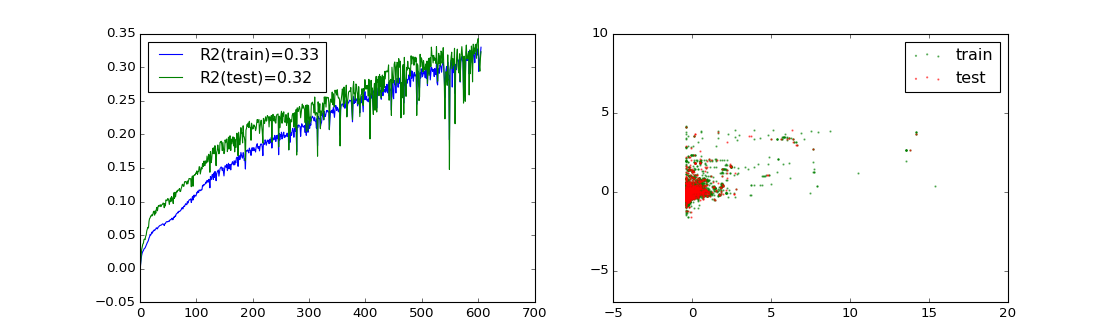

In [17]:
minibatch_size = 32
n_epochs = 300
ns_units = [10, 6, 3]
lr = 1E-2

# Graph
tf.reset_default_graph()

X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 5])

h = X
for n_units in ns_units:
    h = tf.layers.dense(h, units=n_units, activation=tf.nn.elu)
h = tf.layers.dense(h, units=1, activation=None)
yhat = h

y = tf.placeholder(name="y", dtype=tf.float32, shape=[None, 1])

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(loss)

# Session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

m = Minibatch(normalize_analyses, minibatch_size, n_epochs, test_split=0.2, tqdm=True)
b = BetterYhatLive()
while True:
    try:
        _X, _y = m.minibatch()
        sess.run(training_op, feed_dict = {X: _X, y: _y})
        
        if m.i % 100 == 0:
            X_train, y_train = m.training_set()
            yhat_train = sess.run(yhat, feed_dict = {X: X_train})
            X_test, y_test = m.test_set()
            yhat_test = sess.run(yhat, feed_dict = {X: X_test}) 
            b.update(y_train, yhat_train, y_test, yhat_test)
    except StopIteration:
        break

sess.close()

似乎结果不够好。调调参数。

HBox(children=(IntProgress(value=0, max=60665), HTML(value=u'')))

<IPython.core.display.Javascript object>


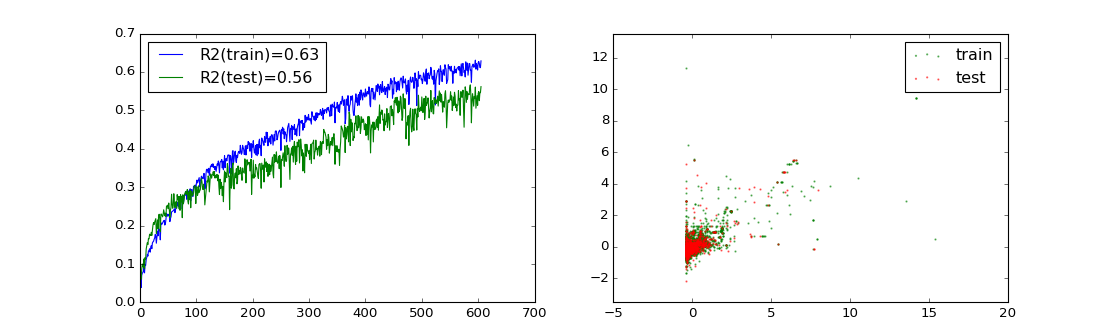

In [26]:
minibatch_size = 32
n_epochs = 300
ns_units = [40, 20, 10]
lr = 1E-3

# Graph
tf.reset_default_graph()

X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 5])

h = X
for n_units in ns_units:
    h = tf.layers.dense(h, units=n_units, activation=tf.nn.elu)
h = tf.layers.dense(h, units=1, activation=None)
yhat = h

y = tf.placeholder(name="y", dtype=tf.float32, shape=[None, 1])

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

# Session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

m = Minibatch(normalize_analyses, minibatch_size, n_epochs, test_split=0.2, tqdm=True)
b = BetterYhatLive()
while True:
    try:
        _X, _y = m.minibatch()
        sess.run(training_op, feed_dict = {X: _X, y: _y})
        
        if m.i % 100 == 0:
            X_train, y_train = m.training_set()
            yhat_train = sess.run(yhat, feed_dict = {X: X_train})
            X_test, y_test = m.test_set()
            yhat_test = sess.run(yhat, feed_dict = {X: X_test}) 
            b.update(y_train, yhat_train, y_test, yhat_test)
    except StopIteration:
        break

sess.close()

In [18]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(normalize_analyses.drop('Waited', axis=1), normalize_analyses.Waited, test_size=0.3)

In [19]:
gpr = sklearn.gaussian_process.GaussianProcessRegressor(alpha=1e-3).fit(X_train, y_train)
yhat_train = gpr.predict(X_train)
yhat_test = gpr.predict(X_test)

<IPython.core.display.Javascript object>


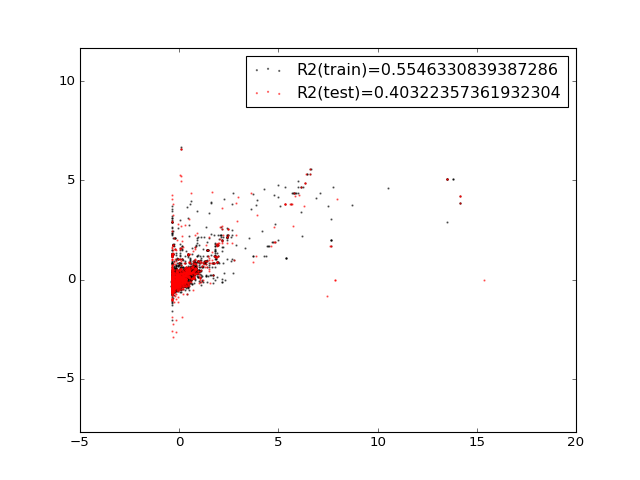

In [22]:
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='datalim')
ax.scatter(y_train, yhat_train, s=1, color='black', alpha=0.5, label='R2(train)=%s'%sklearn.metrics.r2_score(y_train, yhat_train))
ax.scatter(y_test, yhat_test, s=1, color='red', alpha=0.5, label='R2(test)=%s'%sklearn.metrics.r2_score(y_test, yhat_test))
ax.legend()

## 是否完全去掉了0?

<IPython.core.display.Javascript object>


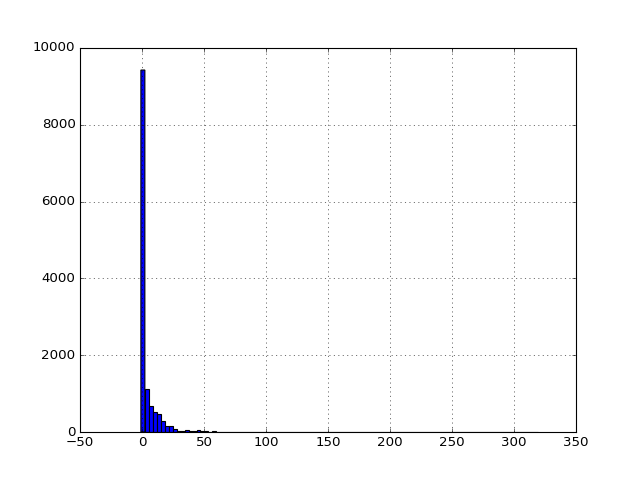

In [39]:
jobs.Waited.hist(bins=100)

In [35]:
len(analyses[analyses.Waited<0.05])

1800

In [33]:
len(analyses)

8088

<IPython.core.display.Javascript object>


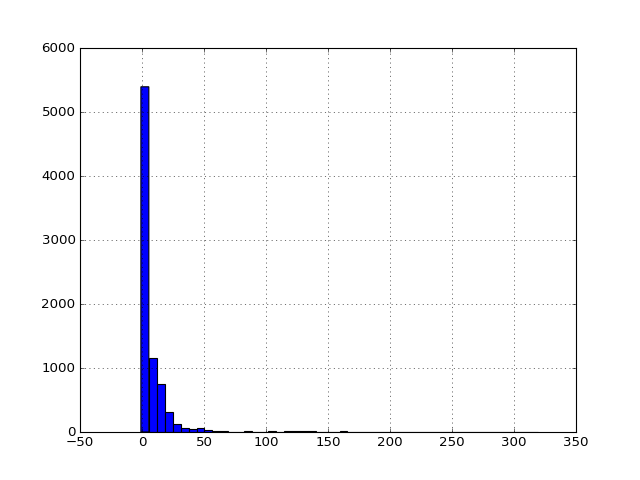

In [34]:
analyses.Waited.hist(bins=50)

In [40]:
analyses.Waited.quantile(q=0.97)

42.61224444444437

<IPython.core.display.Javascript object>


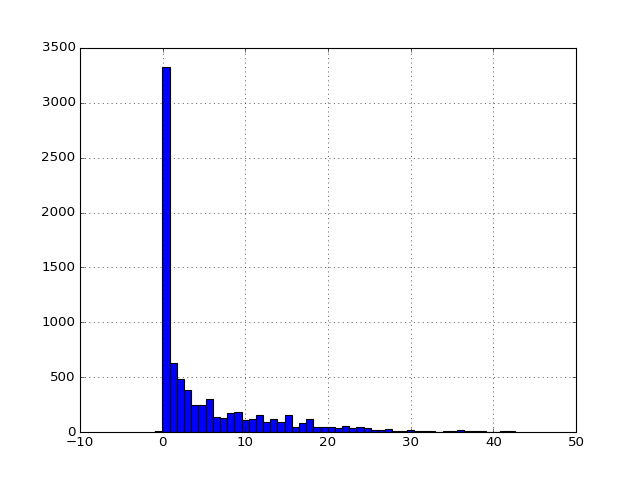

In [41]:
analyses[analyses.Waited < analyses.Waited.quantile(q=0.97)].Waited.hist(bins=50)

In [48]:
len(analyses[analyses.Waited < 0.005])

1260

## 剩下的0是怎么回事？0-0.005 (1200), 0.005-1 (1800)

0-0.005

In [52]:
def count_violation_on_one(tuple_):
    jobs, nnodes, index, tj = tuple_
    
    now = tj.Submit
    
    rj = jobs.loc[np.logical_and.reduce([jobs.index != index, jobs.Submit <= now, jobs.End > now])] # excludes thisjob, includes jobs submitted simultaneously but ranked earlier
    
    # 无关人等滚开
    if now < jobs.End.min() or index < 100:
        return [False, False]
        
    # 零、有空位，就不用等。
    nowait_criterion = rj.NNodes.sum() + tj.NNodes <= nnodes
    nowait = tj.Waited <= 0.005

    if nowait and not nowait_criterion:
        print tj.name
        raise StopIteration

def count_violations_int(nnodes):
    L = multiprocessing.Pool(processes=20).map(count_violation_on_one, [(jobs, nnodes, index, row.copy()) for index, row in jobs.iterrows()])
    return np.sum(np.array(L), axis=0)

def count_violations(nnodes):
    nnodes = int(nnodes)
    if nnodes in count_violations.d:
        result = count_violations.d[nnodes]
    else:
        result = count_violations_int(nnodes)
        count_violations.d[nnodes] = result
    print "%8s, %8s" % (nnodes, result)
    return result
    
count_violations.d = {}


In [ ]:
count_violations_int(36)

Process PoolWorker-123:
Process PoolWorker-115:
Process PoolWorker-110:
Process PoolWorker-116:
Traceback (most recent call last):
Process PoolWorker-117:
Process PoolWorker-112:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Process PoolWorker-125:
Process PoolWorker-120:
Process PoolWorker-128:
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-119:
Traceback (most recent call last):
Process PoolWorker-114:
Process PoolWorker-127:
Traceback (most recent call last):
Process PoolWorker-126:
Process PoolWorker-109:
Process PoolWorker-113:
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
  File "/usr/lib/python2.7/multipro

  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    task = get()
    task = get()
    task = get()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
    racquire()
    racquire()
    racquire()
    racquire()
    racquire()
    racquire()
KeyboardInterrupt
    racquire()
    return recv()
    racquire()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
KeyboardInterrupt
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
    racquire()
    racquire()
    racquire()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worke

In [62]:
index = 767
row = jobs.loc[index]

tj = thisjob = row
now = tj.Submit

rj = relatedjobs = jobs.loc[np.logical_and.reduce([jobs.index != index, jobs.Submit <= now, jobs.End > now])] # excludes thisjob, includes jobs submitted simultaneously but ranked earlier

print '%s self jobs, %s total nodes, %s self nodes' % (np.sum(rj.User == tj.User), rj.NNodes.sum() + tj.NNodes, rj.loc[rj.User == tj.User].NNodes.sum() + tj.NNodes)

75 self jobs, 268 total nodes, 268 self nodes


In [63]:
pd.DataFrame(tj).transpose()

,User,NNodes,Timelimit,Submit,Start,End,Waited
767,huashli,1,0 days 05:00:00,2017-07-22 09:59:48,2017-07-22 10:00:03,2017-07-22 10:00:15,0.00416667


In [64]:
rj

,User,NNodes,Timelimit,Submit,Start,End,Waited
655,huashli,4,2 days 00:00:00,2017-07-22 01:25:41,2017-07-22 09:16:05,2017-07-22 10:13:02,7.840000
656,huashli,4,2 days 00:00:00,2017-07-22 01:25:41,2017-07-22 09:20:51,2017-07-22 10:18:31,7.919444
657,huashli,4,2 days 00:00:00,2017-07-22 01:25:41,2017-07-22 09:24:59,2017-07-22 10:19:03,7.988333
658,huashli,4,2 days 00:00:00,2017-07-22 01:25:41,2017-07-22 09:32:58,2017-07-22 10:31:02,8.121389
659,huashli,4,2 days 00:00:00,2017-07-22 01:25:42,2017-07-22 09:34:09,2017-07-22 10:27:07,8.140833
662,huashli,4,2 days 00:00:00,2017-07-22 01:26:25,2017-07-22 09:48:03,2017-07-22 10:10:05,8.360556
663,huashli,4,2 days 00:00:00,2017-07-22 01:26:25,2017-07-22 09:56:13,2017-07-22 10:31:38,8.496667
664,huashli,4,2 days 00:00:00,2017-07-22 01:33:21,2017-07-22 10:10:05,2017-07-22 10:22:00,8.612222
665,huashli,4,2 days 00:00:00,2017-07-22 01:33:21,2017-07-22 10:13:02,2017-07-22 10:27:47,8.661389
666,huashli,4,2 days 00:00:00,2017-07-22 01:33:21,2017-07-22 10:18:31,2017-07-22 10:30:32,8.752778


0.005-1

In [65]:
def count_violation_on_one(tuple_):
    jobs, nnodes, index, tj = tuple_
    
    now = tj.Submit
    
    rj = jobs.loc[np.logical_and.reduce([jobs.index != index, jobs.Submit <= now, jobs.End > now])] # excludes thisjob, includes jobs submitted simultaneously but ranked earlier
    
    # 无关人等滚开
    if now < jobs.End.min() or index < 100:
        return [False, False]
        
    # 零、有空位，就不用等。
    nowait_criterion = rj.NNodes.sum() + tj.NNodes <= nnodes
    pseudonowait = 0.005 < tj.Waited < 1

    if pseudonowait and not nowait_criterion:
        print tj.name
        raise StopIteration

def count_violations_int(nnodes):
    L = multiprocessing.Pool(processes=20).map(count_violation_on_one, [(jobs, nnodes, index, row.copy()) for index, row in jobs.iterrows()])
    return np.sum(np.array(L), axis=0)

def count_violations(nnodes):
    nnodes = int(nnodes)
    if nnodes in count_violations.d:
        result = count_violations.d[nnodes]
    else:
        result = count_violations_int(nnodes)
        count_violations.d[nnodes] = result
    print "%8s, %8s" % (nnodes, result)
    return result
    
count_violations.d = {}


In [66]:
count_violations_int(36)

200
362


StopIteration: 

100
839
694
546
1342
1200
1089
1845
2039
1602
2226
1780
2857
3010
2712
3344
3200
3678
3563
4682
4847
4563
5348
4435
5209
5540
6017
5877
6195
6353
5744
6684
6854
7018
5176
6575
7352
7201
7519
7702
7857
8036
8354
9025
8574
9361
8288
8780
9867
9563
8949
10206
10378
10533
9325
10718
10906
12229
11215
12659
13495
11999
13158
11711
15226
14088
16122
16516
15741
15098
14734


Process PoolWorker-139:
Process PoolWorker-143:
Process PoolWorker-130:
Process PoolWorker-145:
Process PoolWorker-138:
Process PoolWorker-137:
Process PoolWorker-129:
Process PoolWorker-134:
Process PoolWorker-135:
Process PoolWorker-131:
Process PoolWorker-140:
Process PoolWorker-146:
Process PoolWorker-147:
Traceback (most recent call last):
Process PoolWorker-141:
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-133:
Process PoolWorker-136:
Process PoolWorker-132:
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-148:
Process PoolWorker-144:
Process PoolWorker-142:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258,

    task = get()
    task = get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    return recv()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
    racquire()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
    racquire()
    racquire()
    racquire()
    racquire()
KeyboardInterrupt
KeyboardInterrupt
    racquire()
KeyboardInterrupt
    racquire()
KeyboardInterrupt
    ra

In [74]:
index = 8780
row = jobs.loc[index]

tj = thisjob = row
now = tj.Submit

rj = relatedjobs = jobs.loc[np.logical_and.reduce([jobs.index != index, jobs.Submit <= now, jobs.End > now])] # excludes thisjob, includes jobs submitted simultaneously but ranked earlier

print '%s self jobs, %s total nodes, %s self nodes, cancelled %s' % (np.sum(rj.User == tj.User), rj.NNodes.sum() + tj.NNodes, rj.loc[rj.User == tj.User].NNodes.sum() + tj.NNodes, (tj.End - tj.Start) / pd.Timedelta('1 hour') < 0.05)


2 self jobs, 42 total nodes, 18 self nodes, cancelled False


In [75]:
pd.DataFrame(tj).transpose()

,User,NNodes,Timelimit,Submit,Start,End,Waited
8780,medea,2,2 days 00:00:00,2017-12-23 20:18:16,2017-12-23 20:43:59,2017-12-23 20:57:16,0.428611


In [76]:
rj

,User,NNodes,Timelimit,Submit,Start,End,Waited
8771,xzhang1,8,2 days,2017-12-22 01:40:39,2017-12-22 01:40:40,2017-12-24 01:40:45,0.000278
8773,liuyun,8,2 days,2017-12-22 10:34:27,2017-12-22 10:34:28,2017-12-24 03:15:57,0.000278
8776,liuyun,8,2 days,2017-12-22 10:35:51,2017-12-23 19:17:26,2017-12-24 14:15:41,32.693056
8778,medea,8,2 days,2017-12-22 13:42:28,2017-12-23 20:17:47,2017-12-23 20:28:32,30.588611
8779,medea,8,2 days,2017-12-22 13:45:02,2017-12-23 20:28:32,2017-12-23 20:43:59,30.725000


## 掐头去尾结果？

In [5]:
def read_log():
    jobs = pd.read_csv(filepath_or_buffer='ml_queue.log', sep='\s+', header='infer', skiprows=[1], na_values=['UNLIMITED','Unknown','kijana','root']).dropna()

    jobs.loc[:, 'Submit'] = pd.to_datetime(jobs.loc[:, 'Submit'].copy(), errors='coerce')
    jobs.loc[:, 'Start'] = pd.to_datetime(jobs.loc[:, 'Start'].copy(), errors='coerce')
    jobs.loc[:, 'End'] = pd.to_datetime(jobs.loc[:, 'End'].copy(), errors='coerce')

    jobs.loc[:, 'NNodes'] = pd.to_numeric(jobs.loc[:, 'NNodes'].copy(), errors='coerce', downcast='integer')

    jobs.loc[:, 'Timelimit'] = jobs.loc[:, 'Timelimit'].copy().str.replace('-','day ')
    jobs.loc[:, 'Timelimit'] = pd.to_timedelta(jobs.loc[:, 'Timelimit'].copy(), errors='coerce')
    
    jobs.loc[:, 'Waited'] = (jobs.Start - jobs.Submit).values / pd.Timedelta('1h')

    # jobs = jobs[(np.abs(scipy.stats.zscore(jobs.loc[:,'Wait'].values / pd.Timedelta('1h'))) <3)]
    jobs = jobs.dropna()
    
    # jobs = jobs.sort_values(by = 'Submit')
    # 几乎总是sorted
    
    return jobs

In [6]:
jobs = read_log()

In [7]:
def sample(tuple_):
    
    jobs, index, row = tuple_
    
    tj = thisjob = row
    now = tj.Submit
    
    rj = relatedjobs = jobs.loc[np.logical_and.reduce([jobs.index != index, jobs.Submit <= now, jobs.End > now])] # excludes thisjob, includes jobs submitted simultaneously but ranked earlier
    
    # 无关人等滚开
    if now < jobs.End.min() or index < 100 or index == 10826:
        return None
        
    # 零、有空位，就不用等。
    if rj.NNodes.sum() + tj.NNodes <= 36:
        # 几乎总是tj.Waited < 0.005
        return None
        
    # 一、各种descriptor
    analysis = pd.DataFrame([], index=[index])
    
    analysis.loc[:, 'NNodes'] = tj.NNodes
    analysis.loc[:, 'ETA']    = tj.Timelimit
    
    analysis.loc[:, 'Total_squeue_nnodes'] = rj.NNodes.sum()
    
    analysis.loc[:, 'Total_squeue_eta']    = rj.Timelimit.sum()
    
    analysis.loc[:, 'Self_job_in_squeue_percentage'] = 0 if len(rj)==0 else float(np.sum(rj.User == tj.User)) / len(rj)
    
    analysis.loc[:, 'Waited'] = tj.Waited
    
    return analysis
    
    
L = multiprocessing.Pool(processes=20).map(sample, [(jobs, index, row.copy()) for index, row in tqdm(jobs.iterrows(), total=len(jobs))])
analyses = pd.concat(L) # None is automatically ignored

100%|██████████| 13281/13281 [00:02<00:00, 5798.45it/s]
Process PoolWorker-20:
Process PoolWorker-8:
Process PoolWorker-15:
Process PoolWorker-12:
Process PoolWorker-11:
Process PoolWorker-6:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Process PoolWorker-14:
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-5:
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Process PoolWorker-18:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process PoolWorker-1:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Process PoolWorker-17:


  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
    self._target(*self._args, **self._kwargs)
    racquire()
    task = get()
KeyboardInterrupt
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    racquire()
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
KeyboardInterrupt
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    task = get()
    racquire()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
    racquire()
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
KeyboardInterrupt
Keyb

In [8]:
# 去尾
analyses = analyses[analyses.Waited < analyses.Waited.quantile(q=0.97)].copy()

In [9]:
normalize_analyses = pd.DataFrame(
    sklearn.preprocessing.scale(
        analyses.apply(pd.to_numeric).values
    ), 
    index=analyses.index, 
    columns=analyses.columns
)

/home/xzhang1/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [10]:
print len(jobs), len(normalize_analyses)

13281 7845


HBox(children=(IntProgress(value=0, max=58837), HTML(value=u'')))

<IPython.core.display.Javascript object>


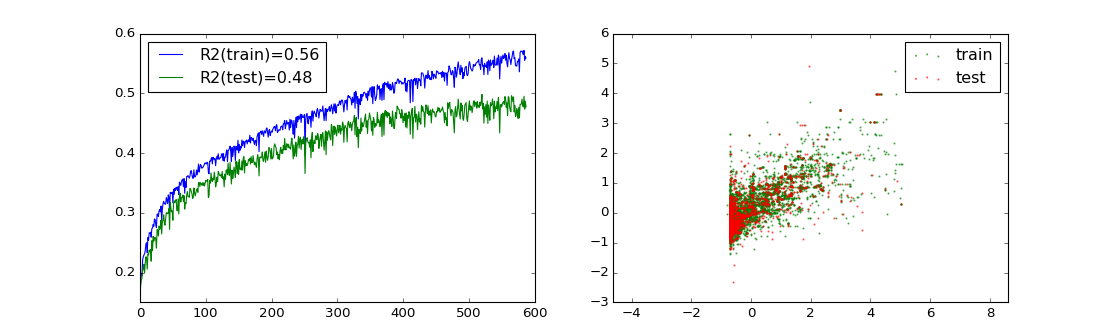

In [87]:
minibatch_size = 32
n_epochs = 300
ns_units = [40, 20, 10]
lr = 1E-3

# Graph
tf.reset_default_graph()

X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 5])

h = X
for n_units in ns_units:
    h = tf.layers.dense(h, units=n_units, activation=tf.nn.elu)
h = tf.layers.dense(h, units=1, activation=None)
yhat = h

y = tf.placeholder(name="y", dtype=tf.float32, shape=[None, 1])

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

# Session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

m = Minibatch(normalize_analyses, minibatch_size, n_epochs, test_split=0.2, tqdm=True)
b = BetterYhatLive()
while True:
    try:
        _X, _y = m.minibatch()
        sess.run(training_op, feed_dict = {X: _X, y: _y})
        
        if m.i % 100 == 0:
            X_train, y_train = m.training_set()
            yhat_train = sess.run(yhat, feed_dict = {X: X_train})
            X_test, y_test = m.test_set()
            yhat_test = sess.run(yhat, feed_dict = {X: X_test}) 
            b.update(y_train, yhat_train, y_test, yhat_test)
    except StopIteration:
        break

sess.close()

In [19]:
class BetterYhatLive(object):
    
    def __init__(self, smoothen):
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(14, 4.2))
        self.ax2.set_aspect('equal', adjustable='datalim')
        self.line11, self.line12 = [], [] # note: line11 means ax1, line1
        self.smoothen = smoothen
        
    def update(self, y_train, yhat_train, y_test, yhat_test):
        self.line11.append(sklearn.metrics.r2_score(y_train, yhat_train))
        self.line12.append(sklearn.metrics.r2_score(y_test, yhat_test))
        # smoothen
        if self.smoothen:
            x = range(len(self.line11))
            smoothline11 = statsmodels.nonparametric.smoothers_lowess.lowess(self.line11, x, is_sorted=True, frac=0.25, it=1, return_sorted=False)
            smoothline12 = statsmodels.nonparametric.smoothers_lowess.lowess(self.line12, x, is_sorted=True, frac=0.25, it=1, return_sorted=False)
        else:
            smoothline11 = self.line11
            smoothline12 = self.line12
        #
        self.ax1.clear()
        self.ax1.plot(smoothline11, label='R2(train)=%.2f'%self.line11[-1])
        self.ax1.plot(smoothline12, label='R2(test)=%.2f'%self.line12[-1])
        self.ax1.legend(loc='best')
        self.ax2.clear()
        self.ax2.scatter(y_train, yhat_train, color='green', s=1, alpha=0.5, label='train')
        self.ax2.scatter(y_test, yhat_test, color='red', s=1, alpha=0.5, label='test')
        self.ax2.legend(loc='best')
        self.fig.canvas.draw()

In [84]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(normalize_analyses.drop('Waited', axis=1), normalize_analyses.Waited, test_size=0.3)

In [85]:
gpr = sklearn.gaussian_process.GaussianProcessRegressor(alpha=1e-3).fit(X_train, y_train)
yhat_train = gpr.predict(X_train)
yhat_test = gpr.predict(X_test)

<IPython.core.display.Javascript object>


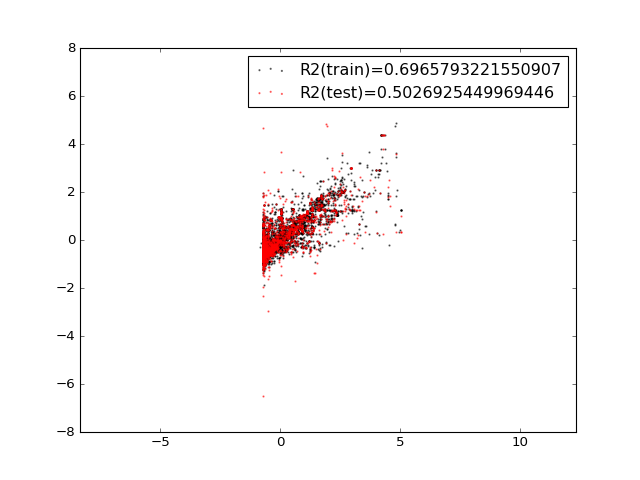

In [86]:
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='datalim')
ax.scatter(y_train, yhat_train, s=1, color='black', alpha=0.5, label='R2(train)=%s'%sklearn.metrics.r2_score(y_train, yhat_train))
ax.scatter(y_test, yhat_test, s=1, color='red', alpha=0.5, label='R2(test)=%s'%sklearn.metrics.r2_score(y_test, yhat_test))
ax.legend()

## 优化gradient descent

HBox(children=(IntProgress(value=0, max=18386), HTML(value=u'')))

<IPython.core.display.Javascript object>


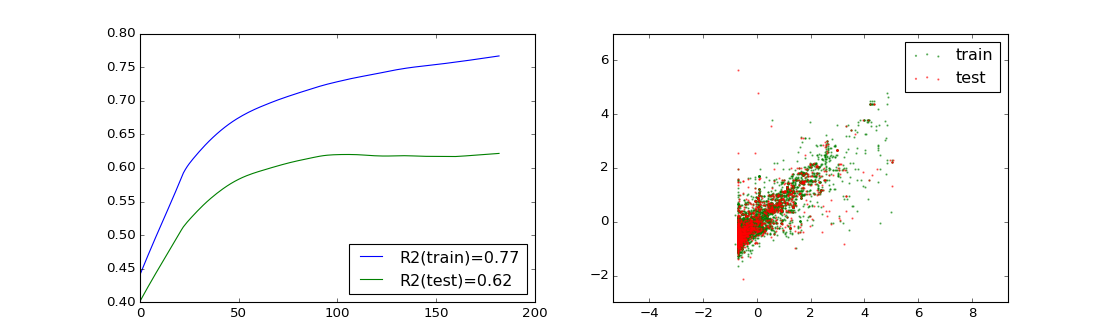

In [27]:
minibatch_size = 2048
n_epochs = 6000
ns_units = [40, 20, 10]
lr = 1E-2

# Graph
tf.reset_default_graph()

X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 5])

h = X
for n_units in ns_units:
    h = tf.layers.dense(h, units=n_units, activation=tf.nn.elu)
h = tf.layers.dense(h, units=1, activation=None)
yhat = h

y = tf.placeholder(name="y", dtype=tf.float32, shape=[None, 1])

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

# Session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

m = Minibatch(normalize_analyses, minibatch_size, n_epochs, test_split=0.2, tqdm=True)
b = BetterYhatLive(smoothen=True)
while True:
    try:
        _X, _y = m.minibatch()
        sess.run(training_op, feed_dict = {X: _X, y: _y})
        
        if m.i % 100 == 0:
            X_train, y_train = m.training_set()
            yhat_train = sess.run(yhat, feed_dict = {X: X_train})
            X_test, y_test = m.test_set()
            yhat_test = sess.run(yhat, feed_dict = {X: X_test}) 
            b.update(y_train, yhat_train, y_test, yhat_test)
    except StopIteration:
        break

sess.close()

In [36]:
len(normalize_analyses) * 0.8 * 5

31380.0

HBox(children=(IntProgress(value=0, max=36773), HTML(value=u'')))

<IPython.core.display.Javascript object>


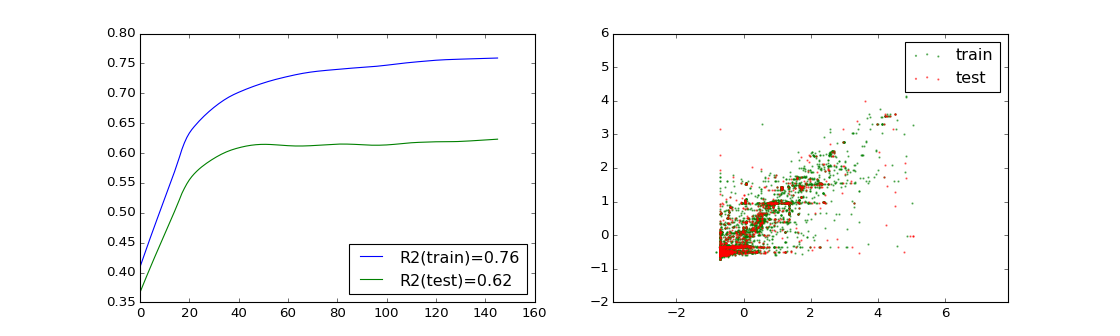

KeyboardInterrupt: 

Process PoolWorker-89:
Process PoolWorker-90:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
    task = get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
    racquire()
KeyboardInterrupt
KeyboardInterrupt


In [49]:
minibatch_size = 2048
n_epochs = 12000
ns_units = [40, 80, 80, 40, 10]
lr = 1E-2

# Graph
tf.reset_default_graph()

keep_prob = tf.placeholder(name="keep_prob", dtype=tf.float32, shape=())

X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 5])

h = X
for n_units in ns_units:
    h = tf.layers.dense(h, units=n_units, activation=tf.nn.elu)
    h = tf.nn.dropout(h, keep_prob=keep_prob)
h = tf.layers.dense(h, units=1, activation=None)
yhat = h

y = tf.placeholder(name="y", dtype=tf.float32, shape=[None, 1])

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

# Session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

m = Minibatch(normalize_analyses, minibatch_size, n_epochs, test_split=0.2, tqdm=True)
b = BetterYhatLive(smoothen=True)
while True:
    try:
        _X, _y = m.minibatch()
        sess.run(training_op, feed_dict = {X: _X, y: _y, keep_prob: 0.8})
        
        if m.i % 100 == 0:
            X_train, y_train = m.training_set()
            yhat_train = sess.run(yhat, feed_dict = {X: X_train, keep_prob: 1.0})
            X_test, y_test = m.test_set()
            yhat_test = sess.run(yhat, feed_dict = {X: X_test, keep_prob: 1.0}) 
            b.update(y_train, yhat_train, y_test, yhat_test)
    except StopIteration:
        break

sess.close()

HBox(children=(IntProgress(value=0, max=36773), HTML(value=u'')))

<IPython.core.display.Javascript object>


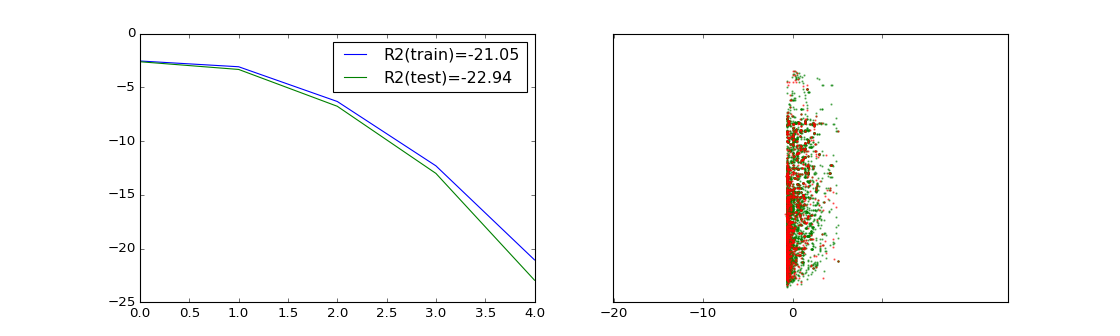

KeyboardInterrupt: 

In [56]:
minibatch_size = 2048
n_epochs = 12000
ns_units = [40, 80, 80, 40, 10]
lr = 1E-2

# Graph
tf.reset_default_graph()

training = tf.placeholder(name="keep_prob", dtype=tf.bool, shape=())

X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 5])

h = X
for n_units in ns_units:
    h = tf.layers.dense(h, units=n_units, activation=tf.nn.elu)
    h = tf.layers.batch_normalization(h, training=training, momentum=0.9999)
h = tf.layers.dense(h, units=1, activation=None)
yhat = h

y = tf.placeholder(name="y", dtype=tf.float32, shape=[None, 1])

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

# Session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

m = Minibatch(normalize_analyses, minibatch_size, n_epochs, test_split=0.2, tqdm=True)
b = BetterYhatLive(smoothen=True)
while True:
    try:
        _X, _y = m.minibatch()
        sess.run(training_op, feed_dict = {X: _X, y: _y, training: True})
        
        if m.i % 100 == 0:
            X_train, y_train = m.training_set()
            yhat_train = sess.run(yhat, feed_dict = {X: X_train, training: False})
            X_test, y_test = m.test_set()
            yhat_test = sess.run(yhat, feed_dict = {X: X_test, training: False}) 
            b.update(y_train, yhat_train, y_test, yhat_test)
    except StopIteration:
        break

sess.close()

In [57]:
normalize_analyses.corr()

,NNodes,ETA,Total_squeue_nnodes,Total_squeue_eta,Self_job_in_squeue_percentage,Waited
NNodes,1.000000,0.209664,0.015859,-0.151174,0.037803,0.142614
ETA,0.209664,1.000000,-0.140306,0.089911,-0.045343,0.032842
Total_squeue_nnodes,0.015859,-0.140306,1.000000,0.717574,0.279265,0.299371
Total_squeue_eta,-0.151174,0.089911,0.717574,1.000000,0.282070,0.150605
Self_job_in_squeue_percentage,0.037803,-0.045343,0.279265,0.282070,1.000000,0.023795
Waited,0.142614,0.032842,0.299371,0.150605,0.023795,1.000000


## 结果与test set选取方式无关

In [59]:
def read_log():
    jobs = pd.read_csv(filepath_or_buffer='ml_queue.log', sep='\s+', header='infer', skiprows=[1], na_values=['UNLIMITED','Unknown','kijana','root']).dropna()

    jobs.loc[:, 'Submit'] = pd.to_datetime(jobs.loc[:, 'Submit'].copy(), errors='coerce')
    jobs.loc[:, 'Start'] = pd.to_datetime(jobs.loc[:, 'Start'].copy(), errors='coerce')
    jobs.loc[:, 'End'] = pd.to_datetime(jobs.loc[:, 'End'].copy(), errors='coerce')

    jobs.loc[:, 'NNodes'] = pd.to_numeric(jobs.loc[:, 'NNodes'].copy(), errors='coerce', downcast='integer')

    jobs.loc[:, 'Timelimit'] = jobs.loc[:, 'Timelimit'].copy().str.replace('-','day ')
    jobs.loc[:, 'Timelimit'] = pd.to_timedelta(jobs.loc[:, 'Timelimit'].copy(), errors='coerce')
    
    jobs.loc[:, 'Waited'] = (jobs.Start - jobs.Submit).values / pd.Timedelta('1h')

    # jobs = jobs[(np.abs(scipy.stats.zscore(jobs.loc[:,'Wait'].values / pd.Timedelta('1h'))) <3)]
    jobs = jobs.dropna()
    
    # jobs = jobs.sort_values(by = 'Submit')
    # 几乎总是sorted
    
    return jobs

In [60]:
jobs = read_log()

In [61]:
def sample(tuple_):
    
    jobs, index, row = tuple_
    
    tj = thisjob = row
    now = tj.Submit
    
    rj = relatedjobs = jobs.loc[np.logical_and.reduce([jobs.index != index, jobs.Submit <= now, jobs.End > now])] # excludes thisjob, includes jobs submitted simultaneously but ranked earlier
    
    # 无关人等滚开
    if now < jobs.End.min() or index < 100 or index == 10826:
        return None
        
    # 零、有空位，就不用等。
    if rj.NNodes.sum() + tj.NNodes <= 36:
        # 几乎总是tj.Waited < 0.005
        return None
        
    # 一、各种descriptor
    analysis = pd.DataFrame([], index=[index])
    
    analysis.loc[:, 'NNodes'] = tj.NNodes
    analysis.loc[:, 'ETA']    = tj.Timelimit
    
    analysis.loc[:, 'Total_squeue_nnodes'] = rj.NNodes.sum()
    
    analysis.loc[:, 'Total_squeue_eta']    = rj.Timelimit.sum()
    
    analysis.loc[:, 'Self_job_in_squeue_percentage'] = 0 if len(rj)==0 else float(np.sum(rj.User == tj.User)) / len(rj)
    
    analysis.loc[:, 'Waited'] = tj.Waited
    
    return analysis
    
    
L = multiprocessing.Pool(processes=20).map(sample, [(jobs, index, row.copy()) for index, row in tqdm(jobs.iterrows(), total=len(jobs))])
analyses = pd.concat(L) # None is automatically ignored

100%|██████████| 13281/13281 [00:02<00:00, 4585.34it/s]
Process PoolWorker-124:
Process PoolWorker-118:
Process PoolWorker-116:
Process PoolWorker-121:
Process PoolWorker-119:
Process PoolWorker-117:
Process PoolWorker-115:
Process PoolWorker-106:
Traceback (most recent call last):
Process PoolWorker-105:
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-107:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process PoolWorker-108:
    self.run()
Process PoolWorker-114:
Traceback (most recent call last):
Process PoolWorker-123:
Traceback (most recent call last):
Process PoolWorker-112:
  File "/usr/lib/python2.7/m

  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    self.run()
KeyboardInterrupt
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    racquire()
    task = get()
    task = get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 378, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    task = get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
KeyboardInterrupt
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    return recv()
    racquire()
    racquire()
    racquire()
KeyboardInterrupt
  File "/usr/lib/python2.7/multiprocessi

In [62]:
# 去尾
analyses = analyses[analyses.Waited < analyses.Waited.quantile(q=0.97)].copy()

In [63]:
normalize_analyses = pd.DataFrame(
    sklearn.preprocessing.scale(
        analyses.apply(pd.to_numeric).values
    ), 
    index=analyses.index, 
    columns=analyses.columns
)

In [83]:
class BetterYhatLive(object):
    
    def __init__(self, smoothen):
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(14, 4.2))
        self.ax2.set_aspect('equal', adjustable='datalim')
        self.line11, self.line12 = [], [] # note: line11 means ax1, line1
        self.smoothen = smoothen
        
    def update(self, y_train, yhat_train, y_test, yhat_test):
        self.line11.append(sklearn.metrics.r2_score(y_train, yhat_train))
        self.line12.append(sklearn.metrics.r2_score(y_test, yhat_test))
        # smoothen
        if self.smoothen:
            x = range(len(self.line11))
            smoothline11 = statsmodels.nonparametric.smoothers_lowess.lowess(self.line11, x, is_sorted=True, frac=0.25, it=1, return_sorted=False)
            smoothline12 = statsmodels.nonparametric.smoothers_lowess.lowess(self.line12, x, is_sorted=True, frac=0.25, it=1, return_sorted=False)
        else:
            smoothline11 = self.line11
            smoothline12 = self.line12
        #
        self.ax1.clear()
        self.ax1.plot(smoothline11, label='R2(train)=%.2f'%self.line11[-1])
        self.ax1.plot(smoothline12, label='R2(test)=%.2f'%self.line12[-1])
        self.ax1.legend(loc='best')
        self.ax2.clear()
        self.ax2.set_aspect('equal', adjustable='datalim')
        self.ax2.scatter(y_train, yhat_train, color='green', s=1, alpha=0.5, label='train')
        self.ax2.scatter(y_test, yhat_test, color='red', s=1, alpha=0.5, label='test')
        self.ax2.legend(loc='best')
        self.fig.canvas.draw()

In [373]:
class Minibatch(object):
    '''
    Makes batches from dataframes.
    Executes n_epochs before raising StopIteration and dying.
    Allows setting aside a test set.
    Progress bar.
    '''
    
    def __init__(self, df, minibatch_size, n_epochs, test_split, random_split, tqdm=False):
        self.minibatch_size = minibatch_size
        
        N = len(df)
        TRAIN = 2000
        TEST = 400
        ALL = TRAIN + TEST
        if random_split == 2:
            M = np.random.randint(TRAIN, N)
            training_index = range(M - TRAIN, M)
            test_index = range(M - TEST, M)  
        elif random_split == 1:
            M = np.random.randint(ALL, N)
            all_index = range(M - ALL, M)
            test_index = np.random.choice(all_index, TEST, replace=False)
            training_index = list(set(all_index) - set(test_index))
        elif random_split == 0:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index = np.random.choice(N, TEST, replace=False)
        elif random_split == -0.1:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index = np.random.choice(list(set(range(N)) - set(training_index)), TEST, replace=False)
        elif random_split == -0.2:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index_pool = set(range(N))
            for delta in [-1, 0, 1]:
                test_index_pool -= set((np.int32(training_index) + delta).tolist())
            test_index = np.random.choice(list(test_index_pool), TEST, replace=False)
        elif random_split == -0.3:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index_pool = set(range(N))
            for delta in [-2, -1, 0, 1, 2]:
                test_index_pool -= set((np.int32(training_index) + delta).tolist())
            test_index = np.random.choice(list(test_index_pool), TEST, replace=False)
        elif random_split == -0.4:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index_pool = set(range(N))
            for delta in [-3, -2, -1, 0, 1, 2, 3]:
                test_index_pool -= set((np.int32(training_index) + delta).tolist())
            test_index = np.random.choice(list(test_index_pool), TEST, replace=False)
        elif random_split == -1:
            training_index = np.random.choice(range(0, N * 3 / 4), TRAIN, replace=False)
            test_index = np.random.choice(range(N * 3 / 4 + 20, N), TEST, replace=False)
        elif random_split == -2:
            M = np.random.randint(TRAIN, N - TEST * 2)
            training_index = range(M - TRAIN, M)
            test_index = range(M + TEST, M + TEST * 2) 
        elif random_split == -9:
            M = np.random.randint(TRAIN, N - TEST)
            test_index = np.random.choice(N, TEST, replace=False)
            training_index = range(M - TRAIN, M)
        self.training_df = df.iloc[training_index]
        self.test_df = df.iloc[test_index]
        self.df = df

        self.i = 0
        self.iMAX = n_epochs * len(self.training_df) / minibatch_size
        
        if tqdm:
            self.tqdm = tqdm_notebook(total=self.iMAX, leave=False)
        
    def minibatch(self):
        if self.i > self.iMAX:
            self.i = 0
            raise StopIteration
        else:
            self.i += 1
            
        if getattr(self, 'tqdm', None):
            self.tqdm.update(1)
        
        index = np.random.choice(range(len(self.training_df)), self.minibatch_size, replace=False)
        return self.training_df.iloc[index, :-1].values, self.training_df.iloc[index, -1].values.reshape(-1, 1)
    
    def training_set(self):
        return self.training_df.iloc[:, :-1].values, self.training_df.iloc[:, -1].values.reshape(-1, 1)
    
    def test_set(self):
        return self.test_df.iloc[:, :-1].values, self.test_df.iloc[:, -1].values.reshape(-1, 1)

In [282]:
# random_split = 2, self cheating

# just see prev P(E1)

HBox(children=(IntProgress(value=0, max=23437), HTML(value=u'')))

<IPython.core.display.Javascript object>


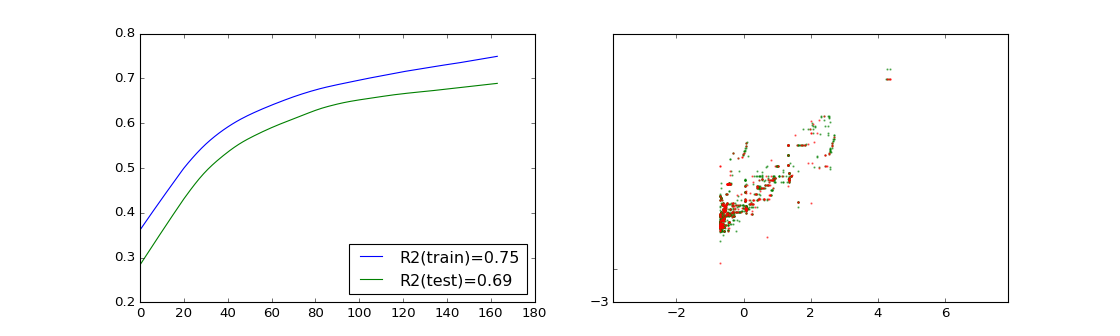

KeyboardInterrupt: 

In [222]:
# random_split = 1, no problem, perfect, obvious

minibatch_size = 64
n_epochs = 1500
ns_units = [20, 20]
lr = 1E-3

# Graph
tf.reset_default_graph()

X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 5])

h = X
for n_units in ns_units:
    h = tf.layers.dense(h, units=n_units, activation=tf.nn.elu)
h = tf.layers.dense(h, units=1, activation=None)
yhat = h

y = tf.placeholder(name="y", dtype=tf.float32, shape=[None, 1])

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

# Session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

m = Minibatch(normalize_analyses, minibatch_size, n_epochs, test_split=0.2, random_split=1, tqdm=True)
b = BetterYhatLive(smoothen=True)
while True:
    try:
        _X, _y = m.minibatch()
        sess.run(training_op, feed_dict = {X: _X, y: _y})
        
        if m.i % 100 == 0:
            X_train, y_train = m.training_set()
            yhat_train = sess.run(yhat, feed_dict = {X: X_train})
            X_test, y_test = m.test_set()
            yhat_test = sess.run(yhat, feed_dict = {X: X_test}) 
            b.update(y_train, yhat_train, y_test, yhat_test)
    except StopIteration:
        break

sess.close()

HBox(children=(IntProgress(value=0, max=23437), HTML(value=u'')))

<IPython.core.display.Javascript object>


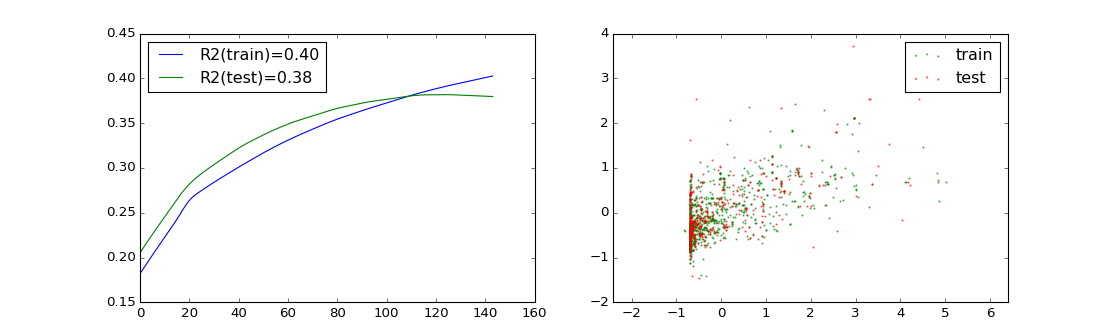

KeyboardInterrupt: 

In [236]:
# random_split = 0, random 1000 and 400, no exclusion can overlap
# witnessed the peak. peak is here, even happens sporadically and percariously.

minibatch_size = 64
n_epochs = 1500
ns_units = [10, 10]
lr = 1E-3

# Graph
tf.reset_default_graph()

X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 5])

h = X
for n_units in ns_units:
    h = tf.layers.dense(h, units=n_units, activation=tf.nn.elu)
h = tf.layers.dense(h, units=1, activation=None)
yhat = h

y = tf.placeholder(name="y", dtype=tf.float32, shape=[None, 1])

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

# Session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

m = Minibatch(normalize_analyses, minibatch_size, n_epochs, test_split=0.2, random_split=0, tqdm=True)
b = BetterYhatLive(smoothen=True)
while True:
    try:
        _X, _y = m.minibatch()
        sess.run(training_op, feed_dict = {X: _X, y: _y})
        
        if m.i % 100 == 0:
            X_train, y_train = m.training_set()
            yhat_train = sess.run(yhat, feed_dict = {X: X_train})
            X_test, y_test = m.test_set()
            yhat_test = sess.run(yhat, feed_dict = {X: X_test}) 
            b.update(y_train, yhat_train, y_test, yhat_test)
    except StopIteration:
        break

sess.close()

HBox(children=(IntProgress(value=0, max=23437), HTML(value=u'')))

<IPython.core.display.Javascript object>


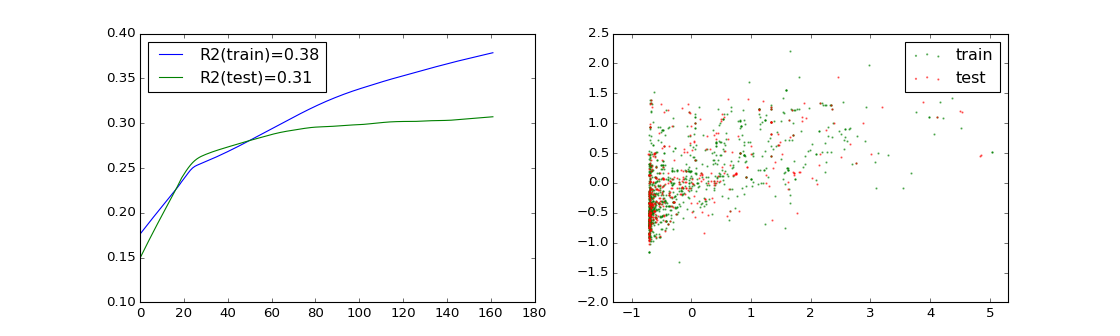

KeyboardInterrupt: 

In [237]:
# random_split = -0.1, random 1000 and 400, exclusion
# i think this is a prime exampmle. u can disagree.

minibatch_size = 64
n_epochs = 1500
ns_units = [10, 10]
lr = 1E-3

# Graph
tf.reset_default_graph()

X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 5])

h = X
for n_units in ns_units:
    h = tf.layers.dense(h, units=n_units, activation=tf.nn.elu)
h = tf.layers.dense(h, units=1, activation=None)
yhat = h

y = tf.placeholder(name="y", dtype=tf.float32, shape=[None, 1])

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

# Session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

m = Minibatch(normalize_analyses, minibatch_size, n_epochs, test_split=0.2, random_split=-0.1, tqdm=True)
b = BetterYhatLive(smoothen=True)
while True:
    try:
        _X, _y = m.minibatch()
        sess.run(training_op, feed_dict = {X: _X, y: _y})
        
        if m.i % 100 == 0:
            X_train, y_train = m.training_set()
            yhat_train = sess.run(yhat, feed_dict = {X: X_train})
            X_test, y_test = m.test_set()
            yhat_test = sess.run(yhat, feed_dict = {X: X_test}) 
            b.update(y_train, yhat_train, y_test, yhat_test)
    except StopIteration:
        break

sess.close()

HBox(children=(IntProgress(value=0, max=23437), HTML(value=u'')))

<IPython.core.display.Javascript object>


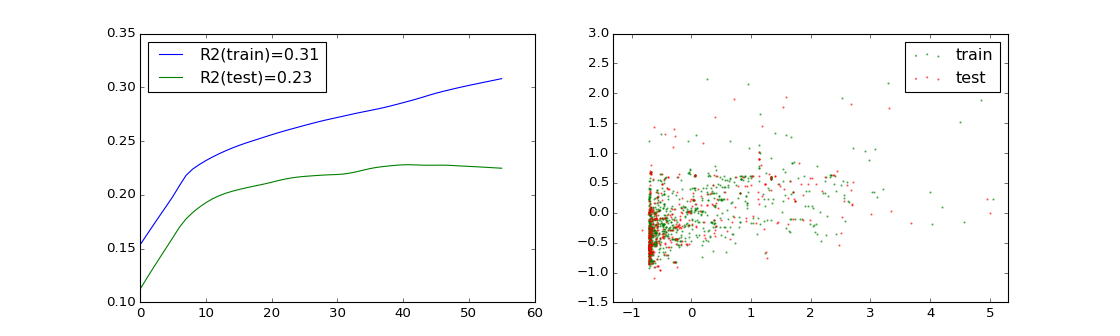

KeyboardInterrupt: 

In [240]:
# random_split = -0.2, random 1000 and 400, exclusion and no near

minibatch_size = 64
n_epochs = 1500
ns_units = [10, 10]
lr = 1E-3

# Graph
tf.reset_default_graph()

X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 5])

h = X
for n_units in ns_units:
    h = tf.layers.dense(h, units=n_units, activation=tf.nn.elu)
h = tf.layers.dense(h, units=1, activation=None)
yhat = h

y = tf.placeholder(name="y", dtype=tf.float32, shape=[None, 1])

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

# Session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

m = Minibatch(normalize_analyses, minibatch_size, n_epochs, test_split=0.2, random_split=-0.2, tqdm=True)
b = BetterYhatLive(smoothen=True)
while True:
    try:
        _X, _y = m.minibatch()
        sess.run(training_op, feed_dict = {X: _X, y: _y})
        
        if m.i % 100 == 0:
            X_train, y_train = m.training_set()
            yhat_train = sess.run(yhat, feed_dict = {X: X_train})
            X_test, y_test = m.test_set()
            yhat_test = sess.run(yhat, feed_dict = {X: X_test}) 
            b.update(y_train, yhat_train, y_test, yhat_test)
    except StopIteration:
        break

sess.close()

HBox(children=(IntProgress(value=0, max=23437), HTML(value=u'')))

<IPython.core.display.Javascript object>


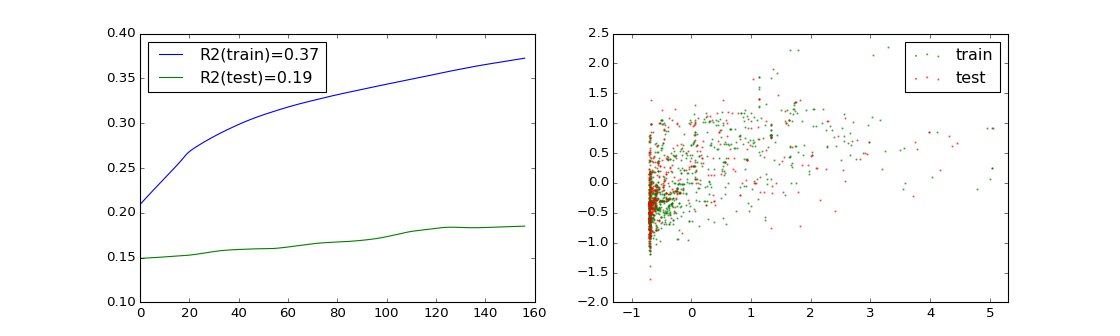

KeyboardInterrupt: 

In [242]:
# random_split = -0.3, random 1000 and 400, exclusion and no near and no near near

minibatch_size = 64
n_epochs = 1500
ns_units = [10, 10]
lr = 1E-3

# Graph
tf.reset_default_graph()

X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 5])

h = X
for n_units in ns_units:
    h = tf.layers.dense(h, units=n_units, activation=tf.nn.elu)
h = tf.layers.dense(h, units=1, activation=None)
yhat = h

y = tf.placeholder(name="y", dtype=tf.float32, shape=[None, 1])

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

# Session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

m = Minibatch(normalize_analyses, minibatch_size, n_epochs, test_split=0.2, random_split=-0.3, tqdm=True)
b = BetterYhatLive(smoothen=True)
while True:
    try:
        _X, _y = m.minibatch()
        sess.run(training_op, feed_dict = {X: _X, y: _y})
        
        if m.i % 100 == 0:
            X_train, y_train = m.training_set()
            yhat_train = sess.run(yhat, feed_dict = {X: X_train})
            X_test, y_test = m.test_set()
            yhat_test = sess.run(yhat, feed_dict = {X: X_test}) 
            b.update(y_train, yhat_train, y_test, yhat_test)
    except StopIteration:
        break

sess.close()

HBox(children=(IntProgress(value=0, max=23437), HTML(value=u'')))

<IPython.core.display.Javascript object>


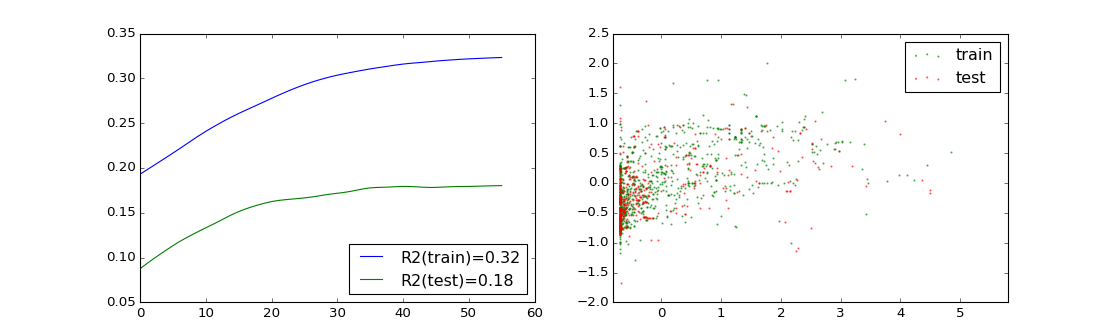

KeyboardInterrupt: 

In [260]:
# random_split = -0.4, random 1000 and 400, exclusion and no near and no near near and no near near near

minibatch_size = 64
n_epochs = 1500
ns_units = [10, 10]
lr = 1E-3

# Graph
tf.reset_default_graph()

X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 5])

h = X
for n_units in ns_units:
    h = tf.layers.dense(h, units=n_units, activation=tf.nn.elu)
h = tf.layers.dense(h, units=1, activation=None)
yhat = h

y = tf.placeholder(name="y", dtype=tf.float32, shape=[None, 1])

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

# Session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

m = Minibatch(normalize_analyses, minibatch_size, n_epochs, test_split=0.2, random_split=-0.4, tqdm=True)
b = BetterYhatLive(smoothen=True)
while True:
    try:
        _X, _y = m.minibatch()
        sess.run(training_op, feed_dict = {X: _X, y: _y})
        
        if m.i % 100 == 0:
            X_train, y_train = m.training_set()
            yhat_train = sess.run(yhat, feed_dict = {X: X_train})
            X_test, y_test = m.test_set()
            yhat_test = sess.run(yhat, feed_dict = {X: X_test}) 
            b.update(y_train, yhat_train, y_test, yhat_test)
    except StopIteration:
        break

sess.close()

HBox(children=(IntProgress(value=0, max=23437), HTML(value=u'')))

<IPython.core.display.Javascript object>


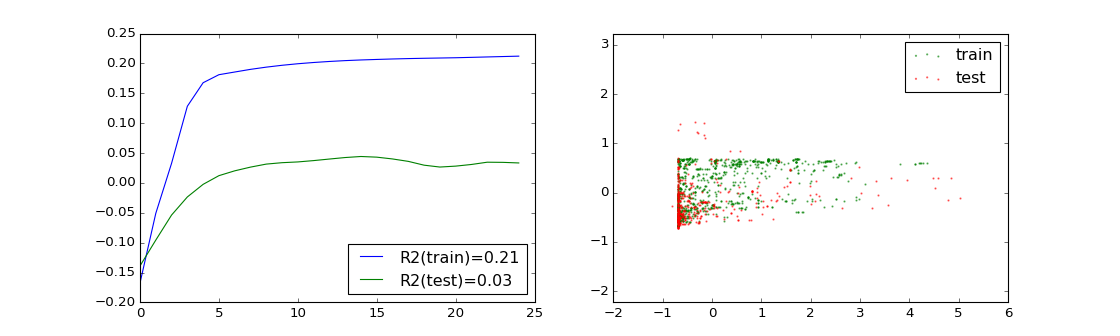

KeyboardInterrupt: 

In [255]:
# random_split = -1, random 1000 and 400, one from first part and one from second part

minibatch_size = 64
n_epochs = 1500
ns_units = [3, 3]
lr = 1E-3

# Graph
tf.reset_default_graph()

X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 5])

h = X
for n_units in ns_units:
    h = tf.layers.dense(h, units=n_units, activation=tf.nn.elu)
h = tf.layers.dense(h, units=1, activation=None)
yhat = h

y = tf.placeholder(name="y", dtype=tf.float32, shape=[None, 1])

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

# Session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

m = Minibatch(normalize_analyses, minibatch_size, n_epochs, test_split=0.2, random_split=-1, tqdm=True)
b = BetterYhatLive(smoothen=True)
while True:
    try:
        _X, _y = m.minibatch()
        sess.run(training_op, feed_dict = {X: _X, y: _y})
        
        if m.i % 100 == 0:
            X_train, y_train = m.training_set()
            yhat_train = sess.run(yhat, feed_dict = {X: X_train})
            X_test, y_test = m.test_set()
            yhat_test = sess.run(yhat, feed_dict = {X: X_test}) 
            b.update(y_train, yhat_train, y_test, yhat_test)
    except StopIteration:
        break

sess.close()

HBox(children=(IntProgress(value=0, max=1500), HTML(value=u'')))

<IPython.core.display.Javascript object>


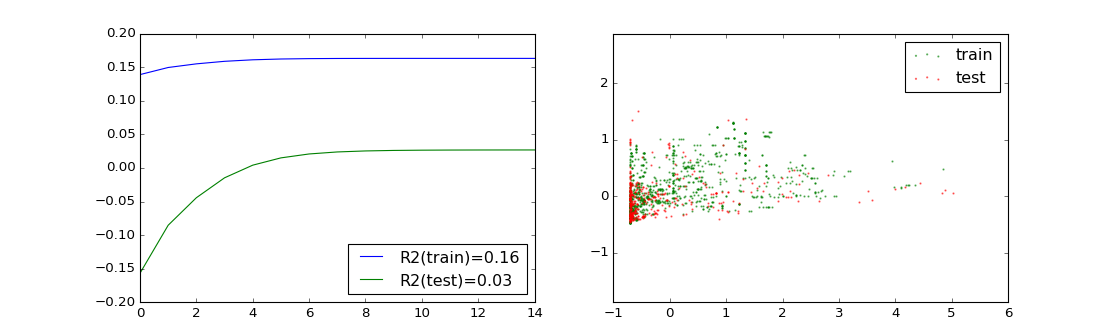

In [258]:
# random_split = -1, random 1000 and 400, one from first part and one from second part
# SGD linear fitting.

minibatch_size = 1000
n_epochs = 1500
lr = 1E-2

# Graph
tf.reset_default_graph()

X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 5])

yhat = tf.layers.dense(X, units=1, activation=None)

y = tf.placeholder(name="y", dtype=tf.float32, shape=[None, 1])

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

# Session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

m = Minibatch(normalize_analyses, minibatch_size, n_epochs, test_split=0.2, random_split=-1, tqdm=True)
b = BetterYhatLive(smoothen=True)
while True:
    try:
        _X, _y = m.minibatch()
        sess.run(training_op, feed_dict = {X: _X, y: _y})
        
        if m.i % 100 == 0:
            X_train, y_train = m.training_set()
            yhat_train = sess.run(yhat, feed_dict = {X: X_train})
            X_test, y_test = m.test_set()
            yhat_test = sess.run(yhat, feed_dict = {X: X_test}) 
            b.update(y_train, yhat_train, y_test, yhat_test)
    except StopIteration:
        break

sess.close()

In [278]:
# random_split = -1, random 1000 and 400, one from first part and one from second part
# actual linear fitting.

minibatch_size = 1000
n_epochs = 1500
lr = 1E-2

m = Minibatch(normalize_analyses, minibatch_size, n_epochs, test_split=0.2, random_split=-1, tqdm=True)
X_train, y_train = m.training_set()
y_train = y_train.reshape(-1)
X_test, y_test = m.test_set()
y_test = y_test.reshape(-1)

reg = sklearn.linear_model.LinearRegression()
reg.fit(X_train, y_train)
yhat_train = reg.predict(X_train)
yhat_test = reg.predict(X_test)
print sklearn.metrics.r2_score(y_train, yhat_train)
print sklearn.metrics.r2_score(y_test, yhat_test)

HBox(children=(IntProgress(value=0, max=1500), HTML(value=u'')))

0.13807301267656802
0.06821915393716826


In [279]:
normalize_analyses.corr()

,NNodes,ETA,Total_squeue_nnodes,Total_squeue_eta,Self_job_in_squeue_percentage,Waited
NNodes,1.000000,0.209664,0.015859,-0.151174,0.037803,0.142614
ETA,0.209664,1.000000,-0.140306,0.089911,-0.045343,0.032842
Total_squeue_nnodes,0.015859,-0.140306,1.000000,0.717574,0.279265,0.299371
Total_squeue_eta,-0.151174,0.089911,0.717574,1.000000,0.282070,0.150605
Self_job_in_squeue_percentage,0.037803,-0.045343,0.279265,0.282070,1.000000,0.023795
Waited,0.142614,0.032842,0.299371,0.150605,0.023795,1.000000


# 解$\hat{W}(A)$，这次注意$E_2$需要有代表性

## 试使train和test还是足够近

In [ ]:
minibatch_size = 256
n_epochs = 240
ns_units = [1]
lr = 1E-2

# Graph
tf.reset_default_graph()

X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 5])

h = X
for n_units in ns_units:
    h = tf.layers.dense(h, units=n_units, activation=tf.nn.elu)
h = tf.layers.dense(h, units=1, activation=None)
yhat = h

y = tf.placeholder(name="y", dtype=tf.float32, shape=[None, 1])

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

# Session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='datalim')
y_trains, yhat_trains, y_tests, yhat_tests = [], [], [], []
for attempts in tnrange(1000):
    m = Minibatch(normalize_analyses, minibatch_size, n_epochs, test_split=0.2, random_split=-2, tqdm=False)
    while True:
        try:
            _X, _y = m.minibatch()
            sess.run(training_op, feed_dict = {X: _X, y: _y})
            
        except StopIteration:
            X_train, y_train = m.training_set()
            yhat_train = sess.run(yhat, feed_dict = {X: X_train})
            X_test, y_test = m.test_set()
            yhat_test = sess.run(yhat, feed_dict = {X: X_test})
            y_trains += y_train.reshape(-1).tolist()
            yhat_trains += yhat_train.reshape(-1).tolist()
            y_tests += y_test.reshape(-1).tolist()
            yhat_tests += yhat_test.reshape(-1).tolist()
            ax.clear()
            ax.scatter(y_trains, yhat_trains, color='green', s=0.5, alpha=0.4, label='R2(train):%s' %sklearn.metrics.r2_score(y_trains, yhat_trains))
            ax.scatter(y_tests, yhat_tests, color='red', s=0.5, alpha=0.8, label='R2(test):%s' %sklearn.metrics.r2_score(y_tests, yhat_tests))
            ax.legend(loc='best')
            fig.canvas.draw()
            break

sess.close()

<IPython.core.display.Javascript object>


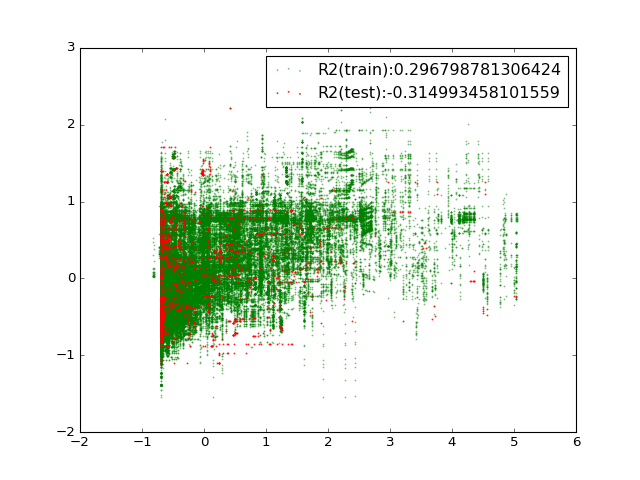

In [371]:
fig, ax = plt.subplots()
ax.scatter(y_trains, yhat_trains, color='green', s=0.5, alpha=0.4, label='R2(train):%s' %sklearn.metrics.r2_score(y_trains, yhat_trains))
ax.scatter(y_tests, yhat_tests, color='red', s=0.5, alpha=0.8, label='R2(test):%s' %sklearn.metrics.r2_score(y_tests, yhat_tests))
ax.legend(loc='best')
fig.canvas.draw()

## 取合式的$E_2$，并提高$E_1$质量

HBox(children=(IntProgress(value=0, max=3906), HTML(value=u'')))

<IPython.core.display.Javascript object>


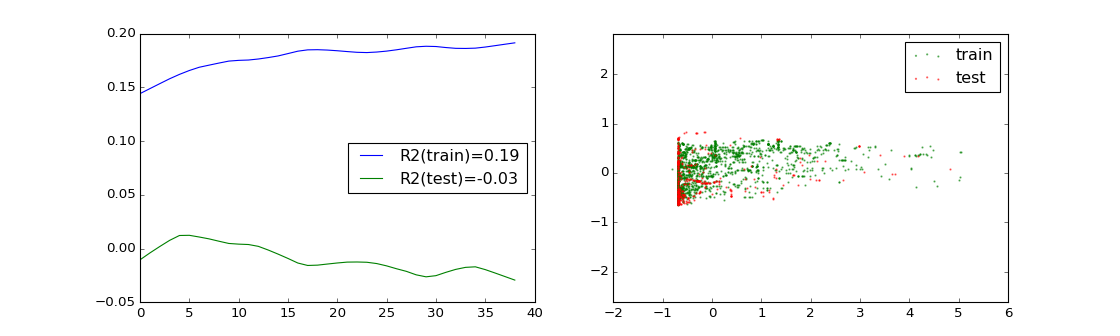

In [390]:
minibatch_size = 512
n_epochs = 1000
ns_units = [10, 10]
lr = 0.02

# Graph
tf.reset_default_graph()

keep_prob = tf.placeholder(name="keep_prob", dtype=tf.float32, shape=())

X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 5])

h = X
for n_units in ns_units:
    h = tf.layers.dense(h, units=n_units, activation=None)
    h = tf.nn.elu(h)
    h = tf.nn.dropout(h, keep_prob=keep_prob)
h = tf.layers.dense(h, units=1, activation=None)
yhat = h

y = tf.placeholder(name="y", dtype=tf.float32, shape=[None, 1])

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.MomentumOptimizer(learning_rate=lr, use_nesterov=True, momentum=0.9).minimize(loss)

# Session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

m = Minibatch(normalize_analyses, minibatch_size, n_epochs, test_split=0.2, random_split=-1, tqdm=True)
b = BetterYhatLive(smoothen=True)
while True:
    try:
        _X, _y = m.minibatch()
        sess.run(training_op, feed_dict = {X: _X, y: _y, keep_prob: 0.40})
        
        if m.i % 100 == 0:
            X_train, y_train = m.training_set()
            yhat_train = sess.run(yhat, feed_dict = {X: X_train, keep_prob: 1.0})
            X_test, y_test = m.test_set()
            yhat_test = sess.run(yhat, feed_dict = {X: X_test, keep_prob: 1.0}) 
            b.update(y_train, yhat_train, y_test, yhat_test)
    except StopIteration:
        break

sess.close()

In [396]:
minibatch_size = 1000
n_epochs = 1500
lr = 1E-2

m = Minibatch(normalize_analyses.loc[:, ['NNodes', 'Total_squeue_nnodes', 'Waited']],
              minibatch_size, n_epochs, test_split=0.2, random_split=-1, tqdm=True)
X_train, y_train = m.training_set()
y_train = y_train.reshape(-1)
X_test, y_test = m.test_set()
y_test = y_test.reshape(-1)

reg = sklearn.linear_model.LinearRegression()
reg.fit(X_train, y_train)
yhat_train = reg.predict(X_train)
yhat_test = reg.predict(X_test)
print sklearn.metrics.r2_score(y_train, yhat_train)
print sklearn.metrics.r2_score(y_test, yhat_test)

HBox(children=(IntProgress(value=0, max=3000), HTML(value=u'')))

0.1376018790570368
-0.12435916948372738


In [406]:
minibatch_size = 1000
n_epochs = 1500
lr = 1E-2

train = analyses.loc[:5500, ['Total_squeue_nnodes', 'Waited']]
test = analyses.loc[5500:5600, ['Total_squeue_nnodes', 'Waited']]
X_train = train.drop('Waited', axis=1)
y_train = train.Waited
X_test = test.drop('Waited', axis=1)
y_test = test.Waited

reg = sklearn.linear_model.LinearRegression()
reg.fit(X_train, y_train)
yhat_train = reg.predict(X_train)
yhat_test = reg.predict(X_test)
print sklearn.metrics.r2_score(y_train, yhat_train)
print sklearn.metrics.r2_score(y_test, yhat_test)

0.18085596086786793
-0.23424918867381095


In [408]:
minibatch_size = 1000
n_epochs = 1500
lr = 1E-2

train = analyses.loc[:5500, ['Total_squeue_nnodes', 'Waited']]
test = analyses.loc[5500:5600, ['Total_squeue_nnodes', 'Waited']]
X_train = train.drop('Waited', axis=1)
y_train = train.Waited
X_test = test.drop('Waited', axis=1)
y_test = test.Waited

gpr = sklearn.gaussian_process.GaussianProcessRegressor(alpha=1e-3).fit(X_train, y_train)
yhat_train = gpr.predict(X_train)
yhat_test = gpr.predict(X_test)
print sklearn.metrics.r2_score(y_train, yhat_train)
print sklearn.metrics.r2_score(y_test, yhat_test)

0.7033102727654043
-4.612898031139259


# Scramble 1. 试edison

In [2]:
def read_log():
    jobs = pd.read_csv(filepath_or_buffer='ml_queue.edison.180501.log', sep='\s+', header='infer', skiprows=[1], na_values=['UNLIMITED','Unknown']).dropna()

    jobs.loc[:, 'Submit'] = pd.to_datetime(jobs.loc[:, 'Submit'].copy(), errors='coerce')
    jobs.loc[:, 'Start'] = pd.to_datetime(jobs.loc[:, 'Start'].copy(), errors='coerce')
    jobs.loc[:, 'End'] = pd.to_datetime(jobs.loc[:, 'End'].copy(), errors='coerce')

    jobs.loc[:, 'NNodes'] = pd.to_numeric(jobs.loc[:, 'NNodes'].copy(), errors='coerce', downcast='integer')

    jobs.loc[:, 'Timelimit'] = jobs.loc[:, 'Timelimit'].copy().str.replace('-','day ')
    jobs.loc[:, 'Timelimit'] = pd.to_timedelta(jobs.loc[:, 'Timelimit'].copy(), errors='coerce')
    
    jobs.loc[:, 'Waited'] = (jobs.Start - jobs.Submit).values / pd.Timedelta('1h')

    # jobs = jobs[(np.abs(scipy.stats.zscore(jobs.loc[:,'Wait'].values / pd.Timedelta('1h'))) <3)]
    jobs = jobs.dropna()
    
    # jobs = jobs.sort_values(by = 'Submit')
    # 几乎总是sorted
    
    return jobs

In [3]:
jobs = read_log()

In [6]:
jobs.iloc[100000]

User                     dmartin
NNodes                         8
Timelimit        0 days 04:00:00
Submit       2018-06-04 01:48:16
Start        2018-06-04 05:00:30
End          2018-06-04 05:01:11
Waited                   3.20389
Name: 917546, dtype: object

In [ ]:
def sample(tuple_):
    
    jobs, index, row = tuple_
    
    tj = thisjob = row
    now = tj.Submit
    
    rj = relatedjobs = jobs.loc[np.logical_and.reduce([jobs.index != index, jobs.Submit <= now, jobs.End > now])] # excludes thisjob, includes jobs submitted simultaneously but ranked earlier
    
    # 无关人等滚开
    if now < jobs.End.min() or index < 100:
        return None
        
    # 一、各种descriptor
    analysis = pd.DataFrame([], index=[index])
    
    analysis.loc[:, 'NNodes'] = tj.NNodes
    analysis.loc[:, 'ETA']    = tj.Timelimit
    
    analysis.loc[:, 'Total_squeue_nnodes'] = rj.NNodes.sum()
    
    analysis.loc[:, 'Total_squeue_eta']    = rj.Timelimit.sum()
    
    analysis.loc[:, 'Self_job_in_squeue_percentage'] = 0 if len(rj)==0 else float(np.sum(rj.User == tj.User)) / len(rj)
    
    analysis.loc[:, 'Waited'] = tj.Waited
    
    return analysis
    
    
L = multiprocessing.Pool(processes=20).map(sample, [(jobs, index, row.copy()) for index, row in tqdm(jobs.iterrows(), total=len(jobs))])
analyses = pd.concat(L) # None is automatically ignored

In [ ]:
# 去尾
analyses = analyses[analyses.Waited < analyses.Waited.quantile(q=0.97)].copy()

In [ ]:
normalize_analyses = pd.DataFrame(
    sklearn.preprocessing.scale(
        analyses.apply(pd.to_numeric).values
    ), 
    index=analyses.index, 
    columns=analyses.columns
)


In [ ]:
# store = pd.HDFStore('ml.queue.edison.180501.h5')
# store['normalize_analyses'] = normalize_analyses

In [ ]:
len(normalize_analyses)

In [ ]:
class BetterYhatLive(object):
    
    def __init__(self, smoothen):
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(14, 4.2))
        self.ax2.set_aspect('equal', adjustable='datalim')
        self.line11, self.line12 = [], [] # note: line11 means ax1, line1
        self.smoothen = smoothen
        
    def update(self, y_train, yhat_train, y_test, yhat_test):
        self.line11.append(sklearn.metrics.r2_score(y_train, yhat_train))
        self.line12.append(sklearn.metrics.r2_score(y_test, yhat_test))
        # smoothen
        if self.smoothen:
            x = range(len(self.line11))
            smoothline11 = statsmodels.nonparametric.smoothers_lowess.lowess(self.line11, x, is_sorted=True, frac=0.25, it=1, return_sorted=False)
            smoothline12 = statsmodels.nonparametric.smoothers_lowess.lowess(self.line12, x, is_sorted=True, frac=0.25, it=1, return_sorted=False)
        else:
            smoothline11 = self.line11
            smoothline12 = self.line12
        #
        self.ax1.clear()
        self.ax1.plot(smoothline11, label='R2(train)=%.2f'%self.line11[-1])
        self.ax1.plot(smoothline12, label='R2(test)=%.2f'%self.line12[-1])
        self.ax1.legend(loc='best')
        self.ax2.clear()
        self.ax2.set_aspect('equal', adjustable='datalim')
        self.ax2.scatter(y_train, yhat_train, color='green', s=1, alpha=0.2, label='train')
        self.ax2.scatter(y_test, yhat_test, color='red', s=1, alpha=0.2, label='test')
        self.ax2.legend(loc='best')
        self.fig.canvas.draw()

In [ ]:
class Minibatch(object):
    '''
    Makes batches from dataframes.
    Executes n_epochs before raising StopIteration and dying.
    Allows setting aside a test set.
    Progress bar.
    '''
    
    def __init__(self, df, minibatch_size, n_epochs, test_split, random_split, tqdm=False):
        self.minibatch_size = minibatch_size
        
        N = len(df)
        TRAIN = 10000
        TEST = 3000
        ALL = TRAIN + TEST
        if random_split == 2:
            M = np.random.randint(TRAIN, N)
            training_index = range(M - TRAIN, M)
            test_index = range(M - TEST, M)  
        elif random_split == 1:
            M = np.random.randint(ALL, N)
            all_index = range(M - ALL, M)
            test_index = np.random.choice(all_index, TEST, replace=False)
            training_index = list(set(all_index) - set(test_index))
        elif random_split == 0:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index = np.random.choice(N, TEST, replace=False)
        elif random_split == -0.1:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index = np.random.choice(list(set(range(N)) - set(training_index)), TEST, replace=False)
        elif random_split == -0.2:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index_pool = set(range(N))
            for delta in [-1, 0, 1]:
                test_index_pool -= set((np.int32(training_index) + delta).tolist())
            test_index = np.random.choice(list(test_index_pool), TEST, replace=False)
        elif random_split == -0.3:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index_pool = set(range(N))
            for delta in [-2, -1, 0, 1, 2]:
                test_index_pool -= set((np.int32(training_index) + delta).tolist())
            test_index = np.random.choice(list(test_index_pool), TEST, replace=False)
        elif random_split == -0.4:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index_pool = set(range(N))
            for delta in [-3, -2, -1, 0, 1, 2, 3]:
                test_index_pool -= set((np.int32(training_index) + delta).tolist())
            test_index = np.random.choice(list(test_index_pool), TEST, replace=False)
        elif random_split == -1:
            training_index = np.random.choice(range(0, N * 3 / 4), TRAIN, replace=False)
            test_index = np.random.choice(range(N * 3 / 4 + 20, N), TEST, replace=False)
        elif random_split == -2:
            M = np.random.randint(TRAIN, N - TEST * 2)
            training_index = range(M - TRAIN, M)
            test_index = range(M + TEST, M + TEST * 2) 
        elif random_split == -3:
            training_index = range(0, N * 4 / 5)
            test_index = range(N * 4 / 5, N) 
        elif random_split == -9:
            M = np.random.randint(TRAIN, N - TEST)
            test_index = np.random.choice(N, TEST, replace=False)
            training_index = range(M - TRAIN, M)
        self.training_df = df.iloc[training_index]
        self.test_df = df.iloc[test_index]
        self.df = df

        self.i = 0
        self.iMAX = n_epochs * len(self.training_df) / minibatch_size
        
        if tqdm:
            self.tqdm = tqdm_notebook(total=self.iMAX, leave=False)
        
    def minibatch(self):
        if self.i > self.iMAX:
            self.i = 0
            raise StopIteration
        else:
            self.i += 1
            
        if getattr(self, 'tqdm', None):
            self.tqdm.update(1)
        
        index = np.random.choice(range(len(self.training_df)), self.minibatch_size, replace=False)
        return self.training_df.iloc[index, :-1].values, self.training_df.iloc[index, -1].values.reshape(-1, 1)
    
    def training_set(self):
        return self.training_df.iloc[:, :-1].values, self.training_df.iloc[:, -1].values.reshape(-1, 1)
    
    def test_set(self):
        return self.test_df.iloc[:, :-1].values, self.test_df.iloc[:, -1].values.reshape(-1, 1)

In [ ]:
# random_split = -3
# tune lr and minibatch_size. note: total=100,000. visual suggests both are good.
# tune nn structure. 
# [10, 5] prob sees a P turning point. decreasing to [5,2] chokes both P's.

minibatch_size = 4096
n_epochs = 100
ns_units = [10, 5]
lr = 1E-3

# Graph
tf.reset_default_graph()

X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 5])

h = X
for n_units in ns_units:
    h = tf.layers.dense(h, units=n_units, activation=tf.nn.elu)
h = tf.layers.dense(h, units=1, activation=None)
yhat = h

y = tf.placeholder(name="y", dtype=tf.float32, shape=[None, 1])

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

# Session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

m = Minibatch(normalize_analyses, minibatch_size, n_epochs, test_split=0.2, random_split=-3, tqdm=True)
b = BetterYhatLive(smoothen=True)
while True:
    try:
        _X, _y = m.minibatch()
        sess.run(training_op, feed_dict = {X: _X, y: _y})
        
        if m.i % 100 == 0:
            X_train, y_train = m.training_set()
            yhat_train = sess.run(yhat, feed_dict = {X: X_train})
            X_test, y_test = m.test_set()
            yhat_test = sess.run(yhat, feed_dict = {X: X_test}) 
            b.update(y_train, yhat_train, y_test, yhat_test)
    except StopIteration:
        break

sess.close()

In [ ]:
r2_trains, r2_tests = [], []

for cut in range(1, 153000, 1000):

    train = normalize_analyses.iloc[:cut]
    test = normalize_analyses.iloc[cut:]
    X_train = train.drop('Waited', axis=1)
    y_train = train.Waited
    X_test = test.drop('Waited', axis=1)
    y_test = test.Waited

    reg = sklearn.linear_model.LinearRegression()
    reg.fit(X_train, y_train)
    yhat_train = reg.predict(X_train)
    yhat_test = reg.predict(X_test)
    r2_trains.append(sklearn.metrics.r2_score(y_train, yhat_train))
    r2_tests.append(sklearn.metrics.r2_score(y_test, yhat_test))

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(0, 153000, 1000), r2_trains, label='R2(trains)', color='green')
ax.plot(range(0, 153000, 1000), r2_tests, label='R2(tests)', color='red')
ax.legend()
ax.set_ylim(-2, 1.5)
ax.set_xlabel('job #')
ax.set_ylabel('R2 value')
rect = patches.Rectangle((55000, 0.12), 85000, 0.35, edgecolor='none', facecolor='yellow')
ax.add_patch(rect)

In [ ]:
import matplotlib.patches as patches

## 既然edison行，凭什么我不行

In [565]:
def read_log():
    jobs = pd.read_csv(filepath_or_buffer='ml_queue.log', sep='\s+', header='infer', skiprows=[1], na_values=['UNLIMITED','Unknown']).dropna()

    jobs.loc[:, 'Submit'] = pd.to_datetime(jobs.loc[:, 'Submit'].copy(), errors='coerce')
    jobs.loc[:, 'Start'] = pd.to_datetime(jobs.loc[:, 'Start'].copy(), errors='coerce')
    jobs.loc[:, 'End'] = pd.to_datetime(jobs.loc[:, 'End'].copy(), errors='coerce')

    jobs.loc[:, 'NNodes'] = pd.to_numeric(jobs.loc[:, 'NNodes'].copy(), errors='coerce', downcast='integer')

    jobs.loc[:, 'Timelimit'] = jobs.loc[:, 'Timelimit'].copy().str.replace('-','day ')
    jobs.loc[:, 'Timelimit'] = pd.to_timedelta(jobs.loc[:, 'Timelimit'].copy(), errors='coerce')
    
    jobs.loc[:, 'Waited'] = (jobs.Start - jobs.Submit).values / pd.Timedelta('1h')

    # jobs = jobs[(np.abs(scipy.stats.zscore(jobs.loc[:,'Wait'].values / pd.Timedelta('1h'))) <3)]
    jobs = jobs.dropna()
    
    # jobs = jobs.sort_values(by = 'Submit')
    # 几乎总是sorted
    
    return jobs

In [566]:
jobs = read_log()

In [567]:
def sample(tuple_):
    
    jobs, index, row = tuple_
    
    tj = thisjob = row
    now = tj.Submit
    
    rj = relatedjobs = jobs.loc[np.logical_and.reduce([jobs.index != index, jobs.Submit <= now, jobs.End > now])] # excludes thisjob, includes jobs submitted simultaneously but ranked earlier
    
    # 无关人等滚开
    if now < jobs.End.min() or index < 100 or index == 10826:
        return None
        
    # 零、有空位，就不用等。
    if rj.NNodes.sum() + tj.NNodes <= 36:
        # 几乎总是tj.Waited < 0.005
        return None
        
    # 一、各种descriptor
    analysis = pd.DataFrame([], index=[index])
    
    analysis.loc[:, 'NNodes'] = tj.NNodes
    analysis.loc[:, 'ETA']    = tj.Timelimit
    
    analysis.loc[:, 'Total_squeue_nnodes'] = rj.NNodes.sum()
    
    analysis.loc[:, 'Total_squeue_eta']    = rj.Timelimit.sum()
    
    analysis.loc[:, 'Self_job_in_squeue_percentage'] = 0 if len(rj)==0 else float(np.sum(rj.User == tj.User)) / len(rj)
    
    analysis.loc[:, 'Waited'] = tj.Waited
    
    return analysis
    
    
L = multiprocessing.Pool(processes=20).map(sample, [(jobs, index, row.copy()) for index, row in tqdm(jobs.iterrows(), total=len(jobs))])
analyses = pd.concat(L) # None is automatically ignored

100%|██████████| 13283/13283 [00:02<00:00, 5208.02it/s]
Process PoolWorker-365:
    task = get()
Traceback (most recent call last):
Process PoolWorker-361:
Process PoolWorker-360:
Process PoolWorker-369:
Process PoolWorker-376:
Process PoolWorker-358:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process PoolWorker-375:
Process PoolWorker-370:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-373:
Process PoolWorker-364:
Process PoolWorker-374:
Process PoolWorker-366:
Process PoolWorker-367:
Process PoolWorker-371:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-368:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multi

  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    task = get()
KeyboardInterrupt
    racquire()
    racquire()
    self._target(*self._args, **self._kwargs)
    racquire()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
    racquire()
KeyboardInterrupt
KeyboardInterrupt
    racquire()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
KeyboardInterrupt
    task = get()
    task = get()
    task = get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 378, in get
  File "/usr/lib/py

In [568]:
# 去尾
analyses = analyses[analyses.Waited < analyses.Waited.quantile(q=0.97)].copy()

In [569]:
normalize_analyses = pd.DataFrame(
    sklearn.preprocessing.scale(
        analyses.apply(pd.to_numeric).values
    ), 
    index=analyses.index, 
    columns=analyses.columns
)


In [570]:
# store = pd.HDFStore('ml.queue.edison.180501.h5')
# store['normalize_analyses'] = normalize_analyses

In [571]:
len(normalize_analyses)

7845

In [572]:
class BetterYhatLive(object):
    
    def __init__(self, smoothen):
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(14, 4.2))
        self.ax2.set_aspect('equal', adjustable='datalim')
        self.line11, self.line12 = [], [] # note: line11 means ax1, line1
        self.smoothen = smoothen
        
    def update(self, y_train, yhat_train, y_test, yhat_test):
        self.line11.append(sklearn.metrics.r2_score(y_train, yhat_train))
        self.line12.append(sklearn.metrics.r2_score(y_test, yhat_test))
        # smoothen
        if self.smoothen:
            x = range(len(self.line11))
            smoothline11 = statsmodels.nonparametric.smoothers_lowess.lowess(self.line11, x, is_sorted=True, frac=0.25, it=1, return_sorted=False)
            smoothline12 = statsmodels.nonparametric.smoothers_lowess.lowess(self.line12, x, is_sorted=True, frac=0.25, it=1, return_sorted=False)
        else:
            smoothline11 = self.line11
            smoothline12 = self.line12
        #
        self.ax1.clear()
        self.ax1.plot(smoothline11, label='R2(train)=%.2f'%self.line11[-1])
        self.ax1.plot(smoothline12, label='R2(test)=%.2f'%self.line12[-1])
        self.ax1.legend(loc='best')
        self.ax2.clear()
        self.ax2.set_aspect('equal', adjustable='datalim')
        self.ax2.scatter(y_train, yhat_train, color='green', s=1, alpha=0.2, label='train')
        self.ax2.scatter(y_test, yhat_test, color='red', s=1, alpha=0.2, label='test')
        self.ax2.legend(loc='best')
        self.fig.canvas.draw()

In [573]:
class Minibatch(object):
    '''
    Makes batches from dataframes.
    Executes n_epochs before raising StopIteration and dying.
    Allows setting aside a test set.
    Progress bar.
    '''
    
    def __init__(self, df, minibatch_size, n_epochs, test_split, random_split, tqdm=False):
        self.minibatch_size = minibatch_size
        
        N = len(df)
        TRAIN = 10000
        TEST = 3000
        ALL = TRAIN + TEST
        if random_split == 2:
            M = np.random.randint(TRAIN, N)
            training_index = range(M - TRAIN, M)
            test_index = range(M - TEST, M)  
        elif random_split == 1:
            M = np.random.randint(ALL, N)
            all_index = range(M - ALL, M)
            test_index = np.random.choice(all_index, TEST, replace=False)
            training_index = list(set(all_index) - set(test_index))
        elif random_split == 0:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index = np.random.choice(N, TEST, replace=False)
        elif random_split == -0.1:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index = np.random.choice(list(set(range(N)) - set(training_index)), TEST, replace=False)
        elif random_split == -0.2:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index_pool = set(range(N))
            for delta in [-1, 0, 1]:
                test_index_pool -= set((np.int32(training_index) + delta).tolist())
            test_index = np.random.choice(list(test_index_pool), TEST, replace=False)
        elif random_split == -0.3:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index_pool = set(range(N))
            for delta in [-2, -1, 0, 1, 2]:
                test_index_pool -= set((np.int32(training_index) + delta).tolist())
            test_index = np.random.choice(list(test_index_pool), TEST, replace=False)
        elif random_split == -0.4:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index_pool = set(range(N))
            for delta in [-3, -2, -1, 0, 1, 2, 3]:
                test_index_pool -= set((np.int32(training_index) + delta).tolist())
            test_index = np.random.choice(list(test_index_pool), TEST, replace=False)
        elif random_split == -1:
            training_index = np.random.choice(range(0, N * 3 / 4), TRAIN, replace=False)
            test_index = np.random.choice(range(N * 3 / 4 + 20, N), TEST, replace=False)
        elif random_split == -2:
            M = np.random.randint(TRAIN, N - TEST * 2)
            training_index = range(M - TRAIN, M)
            test_index = range(M + TEST, M + TEST * 2) 
        elif random_split == -3:
            training_index = range(0, N * 4 / 5)
            test_index = range(N * 4 / 5, N) 
        elif random_split == -9:
            M = np.random.randint(TRAIN, N - TEST)
            test_index = np.random.choice(N, TEST, replace=False)
            training_index = range(M - TRAIN, M)
        self.training_df = df.iloc[training_index]
        self.test_df = df.iloc[test_index]
        self.df = df

        self.i = 0
        self.iMAX = n_epochs * len(self.training_df) / minibatch_size
        
        if tqdm:
            self.tqdm = tqdm_notebook(total=self.iMAX, leave=False)
        
    def minibatch(self):
        if self.i > self.iMAX:
            self.i = 0
            raise StopIteration
        else:
            self.i += 1
            
        if getattr(self, 'tqdm', None):
            self.tqdm.update(1)
        
        index = np.random.choice(range(len(self.training_df)), self.minibatch_size, replace=False)
        return self.training_df.iloc[index, :-1].values, self.training_df.iloc[index, -1].values.reshape(-1, 1)
    
    def training_set(self):
        return self.training_df.iloc[:, :-1].values, self.training_df.iloc[:, -1].values.reshape(-1, 1)
    
    def test_set(self):
        return self.test_df.iloc[:, :-1].values, self.test_df.iloc[:, -1].values.reshape(-1, 1)

HBox(children=(IntProgress(value=0, max=7354), HTML(value=u'')))

<IPython.core.display.Javascript object>


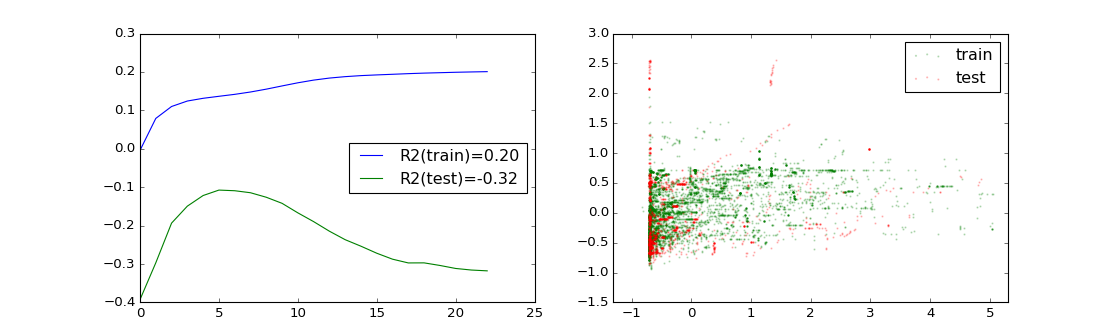

KeyboardInterrupt: 

In [574]:
# random_split = -3
# tune lr and minibatch_size. note: total=100,000. visual suggests both are good.
# tune nn structure. 
# [3, 2] prob sees a P turning point. decreasing to [3] chokes both P's.

minibatch_size = 256
n_epochs = 300
ns_units = [3, 2]
lr = 1E-3

# Graph
tf.reset_default_graph()

X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 5])

h = X
for n_units in ns_units:
    h = tf.layers.dense(h, units=n_units, activation=tf.nn.elu)
h = tf.layers.dense(h, units=1, activation=None)
yhat = h

y = tf.placeholder(name="y", dtype=tf.float32, shape=[None, 1])

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

# Session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

m = Minibatch(normalize_analyses, minibatch_size, n_epochs, test_split=0.2, random_split=-3, tqdm=True)
b = BetterYhatLive(smoothen=True)
while True:
    try:
        _X, _y = m.minibatch()
        sess.run(training_op, feed_dict = {X: _X, y: _y})
        
        if m.i % 100 == 0:
            X_train, y_train = m.training_set()
            yhat_train = sess.run(yhat, feed_dict = {X: X_train})
            X_test, y_test = m.test_set()
            yhat_test = sess.run(yhat, feed_dict = {X: X_test}) 
            b.update(y_train, yhat_train, y_test, yhat_test)
    except StopIteration:
        break

sess.close()

In [576]:
r2_trains, r2_tests = [], []

for cut in range(1, 8000, 500):

    train = normalize_analyses.iloc[:cut]
    test = normalize_analyses.iloc[cut:]
    X_train = train.drop('Waited', axis=1)
    y_train = train.Waited
    X_test = test.drop('Waited', axis=1)
    y_test = test.Waited

    reg = sklearn.linear_model.LinearRegression()
    reg.fit(X_train, y_train)
    yhat_train = reg.predict(X_train)
    yhat_test = reg.predict(X_test)
    r2_trains.append(sklearn.metrics.r2_score(y_train, yhat_train))
    r2_tests.append(sklearn.metrics.r2_score(y_test, yhat_test))

<IPython.core.display.Javascript object>


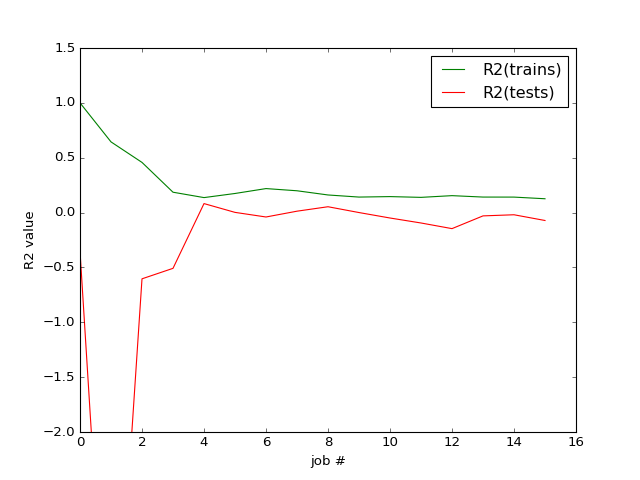

In [577]:
fig, ax = plt.subplots()
ax.plot(r2_trains, label='R2(trains)', color='green')
ax.plot(r2_tests, label='R2(tests)', color='red')
ax.legend()
ax.set_ylim(-2, 1.5)
ax.set_xlabel('job #')
ax.set_ylabel('R2 value')
rect = patches.Rectangle((55000, 0.12), 85000, 0.35, edgecolor='none', facecolor='yellow')
ax.add_patch(rect)

<IPython.core.display.Javascript object>


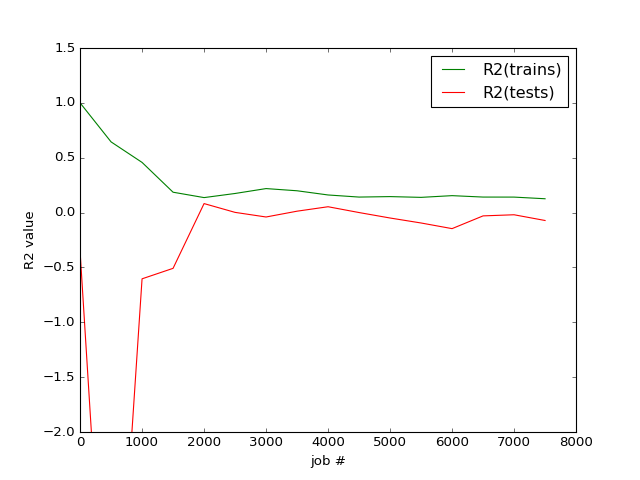

In [581]:
fig, ax = plt.subplots()
ax.plot(range(1, 8000, 500), r2_trains, label='R2(trains)', color='green')
ax.plot(range(1, 8000, 500), r2_tests, label='R2(tests)', color='red')
ax.legend()
ax.set_ylim(-2, 1.5)
ax.set_xlabel('job #')
ax.set_ylabel('R2 value')
rect = patches.Rectangle((55000, 0.12), 85000, 0.35, edgecolor='none', facecolor='yellow')
ax.add_patch(rect)

# Trash

In [578]:
analyses.head()

,NNodes,ETA,Total_squeue_nnodes,Total_squeue_eta,Self_job_in_squeue_percentage,Waited
100,2,10:00:00,68.0,23 days 20:00:00,0.863636,0.796944
101,2,10:00:00,74.0,25 days 02:00:00,0.880000,0.873889
102,2,10:00:00,74.0,25 days 02:00:00,0.880000,0.903889
103,2,10:00:00,74.0,25 days 02:00:00,0.880000,0.915556
104,2,10:00:00,76.0,25 days 12:00:00,0.884615,1.332500


In [23]:
def f(x):
    return (float(x)-5.1)**2

search_space = {
    'x': {
        '5': None,
        '6': None
    }
}

optunity.minimize_structured(f, search_space=search_space, num_evals=10)

({'x': '5'},
 optimize_results(optimum=0.009999999999999929, stats=OrderedDict([('num_evals', 2), ('time', 0.013106107711791992)]), call_log={'args': {'x': ['6', '5']}, 'values': [0.8100000000000006, 0.009999999999999929]}, report=None),
 {'num_generations': 1,
  'num_particles': 10,
  'solver_name': 'particle swarm',
  'x': [0.0, 2.0]})

In [ ]:
def sample(tuple_):
    
    jobs, index, row = tuple_
    
    tj = thisjob = row
    now = tj.Submit
    
    rj = relatedjobs = jobs.loc[np.logical_and.reduce([jobs.index != index, jobs.Submit <= now, jobs.End > now])] # excludes thisjob, includes jobs submitted simultaneously but ranked earlier
    
    # 无关人等滚开
    if now < jobs.End.min() or index < 100 or index == 10826:
        return None
        
    # 零、有空位，就不用等。
    if rj.NNodes.sum() + tj.NNodes <= 32 and np.sum(rj.User == tj.User)<=16 and rj.loc[rj.User == tj.User].NNodes.sum() + tj.NNodes<=16: 
        if tj.Waited >= 0.05:
            print tj
        return None
    
    # 为什么没等？
    if tj.Waited < 0.05:
        print tj.name
        
    # 一、各种descriptor
    analysis = pd.DataFrame([], index=[index])
    
    analysis.loc[:, 'NNodes'] = tj.NNodes
    analysis.loc[:, 'ETA']    = tj.Timelimit
    
    analysis.loc[:, 'Total_squeue_nnodes'] = rj.NNodes.sum()
    
    analysis.loc[:, 'Total_squeue_eta']    = rj.Timelimit.sum()
    
    analysis.loc[:, 'Self_job_in_squeue_percentage'] = 0 if len(rj)==0 else float(np.sum(rj.User == tj.User)) / len(rj)
    
    analysis.loc[:, 'Waited'] = tj.Waited
    
    return analysis
    
    
L = multiprocessing.Pool(processes=20).map(sample, [(jobs, index, row.copy()) for index, row in tqdm(jobs.iterrows(), total=len(jobs))])
analyses = pd.concat(L) # None is automatically ignored

In [126]:
index = 198
row = jobs.loc[index]

tj = thisjob = row
now = tj.Submit

rj = relatedjobs = jobs.loc[np.logical_and.reduce([jobs.index != index, jobs.Submit <= now, jobs.End > now])] # excludes thisjob, includes jobs submitted simultaneously but ranked earlier

print '%s self jobs, %s total nodes, %s self nodes' % (np.sum(rj.User == tj.User), rj.NNodes.sum() + tj.NNodes, rj.loc[rj.User == tj.User].NNodes.sum() + tj.NNodes)

16 self jobs, 35 total nodes, 17 self nodes


rj

In [ ]:
pd.DataFrame(tj).transpose()

In [ ]:
analyses[analyses.Waited==0]

In [ ]:
for index in analyses.index[analyses.Waited==0]:
    row = jobs.loc[index]
    
    tj = thisjob = row
    now = tj.Submit

    rj = relatedjobs = jobs.loc[np.logical_and.reduce([jobs.index != index, jobs.Submit <= now, jobs.End > now])] # excludes thisjob, includes jobs submitted simultaneously but ranked earlier
    print rj.NNodes.sum() + tj.NNodes
    